In [2]:
from config.config import CONFIGURATION_PATH
import utils.images_utils as hlpimage
import utils.analysis_utils as hlpeda
from matplotlib import pyplot as plt
from IPython.display import display
import utils.read_utils as hlpread
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np  
import gc
import os

In [ ]:
current_dir = os.path.dirname(os.path.realpath('__file__'))
PROJECT_ROOT = os.path.abspath(os.path.join(current_dir, os.pardir))

In [ ]:
CUSTOMER_MASTER_TABLE = os.path.join(PROJECT_ROOT, 
                                     hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                                     hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','raw_data'),
                                     hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','customer_data'),
                                    )

In [ ]:
ARTICLES_MASTER_TABLE = os.path.join(PROJECT_ROOT, 
                                     hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                                     hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','raw_data'),
                                     hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','article_data'),
                                    )

In [ ]:
TRANSACTION_DATA = os.path.join(PROJECT_ROOT, 
                                     hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                                     hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','raw_data'),
                                     hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','transaction_data'),
                                    )

In [ ]:
MISSING_ITEM_IMAGES = os.path.join(PROJECT_ROOT, 
                                   hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                                   hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','interim_data'),
                                   hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','item_image_missing'),
                                   )

## Customer data ##

1. Reduce size by changing the data type.
2. Missing data
3. Outlier

In [8]:
#bool_column = lambda x: ( False if pd.isna(x) else True)
categorical_column = lambda x: ('NONE' if pd.isna(x) or len(x) == 0 else 'NONE' if x =='None' else x)

df_customer = pd.read_csv(CUSTOMER_MASTER_TABLE,
                          converters = 
                                      {                                      
                                       'fashion_news_frequency': categorical_column   
                                      },
                          usecols = ['customer_id', 'FN', 'Active', 'club_member_status','fashion_news_frequency', 'age'],
                          dtype = 
                                  {
                                    'club_member_status': 'category'                                   
                                  }                          
                         )


df_customer.FN.fillna(0, inplace = True)
df_customer.FN = df_customer.FN.astype(bool)

df_customer.Active.fillna(0, inplace = True)
df_customer.Active = df_customer.Active.astype(bool)

df_customer.rename(columns = {'FN':'subscribe_fashion_newsletter','Active':'active'}, inplace = True)
df_customer['fashion_news_frequency'] = df_customer['fashion_news_frequency'].astype('category')

df_customer.customer_id = df_customer.customer_id.apply(lambda x: int(x[-16:],16) ).astype('int64')
df_customer.head()

,customer_id,subscribe_fashion_newsletter,active,club_member_status,fashion_news_frequency,age
0,6883939031699146327,False,False,ACTIVE,NONE,49.0
1,-7200416642310594310,False,False,ACTIVE,NONE,25.0
2,-6846340800584936,False,False,ACTIVE,NONE,24.0
3,-94071612138601410,False,False,ACTIVE,NONE,54.0
4,-283965518499174310,True,True,ACTIVE,Regularly,52.0


### Cleaning 'Age' features: ###
1. Outlier, where max age of customers is 99 
2. Missing values 


In [9]:
df_customer.age.describe()

count    1.356119e+06
mean     3.638696e+01
std      1.431363e+01
min      1.600000e+01
25%      2.400000e+01
50%      3.200000e+01
75%      4.900000e+01
max      9.900000e+01
Name: age, dtype: float64

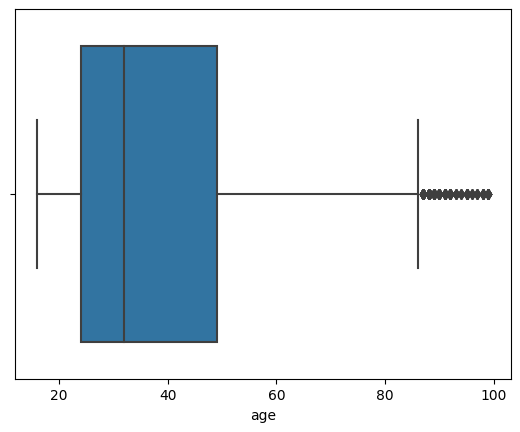

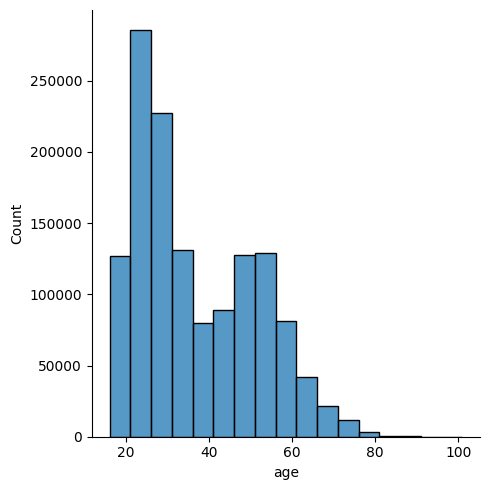

In [21]:
sns.boxplot(x = df_customer.age)
sns.displot(df_customer, x = "age",  binwidth = 5)
plt.show()

**Observartion:**

1. 50% percentile of user are in age range of 20-35
2. There is a customer with age of 99 which we can be treated as outlier. So we need to drop user with age of 99. i.e any user with age more then Q3 will be consider as outlier.
3. Customer with missing age have made traansion in last 3 month transaction data. Based on blox plot it is right skewed so replacing missinge age with mean will not give good idea. So we shall replace missing values with median.


#### Remove Outlier ####

In [23]:
#Since we have nan value in age column np.percentile was always giving nan output
Q1, Q3 = np.nanpercentile(df_customer.age, [25, 75]) 

print('Q1 25 percentile of the given data is, ', Q1)
print('Q1 75 percentile of the given data is, ', Q3)
  
IQR = Q3 - Q1 
print('Interquartile range is', IQR)
up_lim = Q3 + 1.5 * IQR
print('Upper limit is', up_lim)

#Instead of droping the customer we shall mark them as outlier in a seperate column
df_customer['is_outlier'] = df_customer.age > up_lim

Q1 25 percentile of the given data is,  24.0
Q1 75 percentile of the given data is,  49.0
Interquartile range is 25.0
Upper limit is 86.5


In [25]:
#df_customer.age = pd.to_numeric(df_customer.age, downcast='unsigned')
age_median = df_customer.age.median(skipna = True)
print(f'Median age: {age_median}')
df_customer.age = df_customer.age.fillna(value = age_median)
df_customer.age = np.uint8(df_customer.age)

Median age: 32.0


In [26]:
df_customer.head()

,customer_id,subscribe_fashion_newsletter,active,club_member_status,fashion_news_frequency,age,is_outlier
0,6883939031699146327,False,False,ACTIVE,NONE,49,False
1,-7200416642310594310,False,False,ACTIVE,NONE,25,False
2,-6846340800584936,False,False,ACTIVE,NONE,24,False
3,-94071612138601410,False,False,ACTIVE,NONE,54,False
4,-283965518499174310,True,True,ACTIVE,Regularly,52,False


## Transaction data ##

In [3]:

df_transaction = pd.read_pickle(TRANSACTION_DATA, 
                                compression = 'gzip'                                  
                               )

df_transaction.t_dat = pd.to_datetime(df_transaction.t_dat)

df_transaction.article_id = pd.to_numeric(df_transaction.article_id, downcast = 'unsigned')

df_transaction.price = df_transaction.price.astype('float16')

df_transaction.customer_id = df_transaction.customer_id.apply(lambda x: int(x[-16:],16) ).astype('int64')

df_transaction.sales_channel_id =  df_transaction.sales_channel_id.apply(lambda x: False if (x == 1) else True)
df_transaction.rename(columns = {'sales_channel_id':'online_sale'}, inplace = True)

print("Shape of transaction records:" + str(df_transaction.shape))

df_transaction.head()

Shape of transaction records:(31788324, 5)


,t_dat,customer_id,article_id,price,online_sale
0,2018-09-20,-6846340800584936,663713001,0.050842,True
1,2018-09-20,-6846340800584936,541518023,0.030487,True
2,2018-09-20,-8334631767138808638,505221004,0.015236,True
3,2018-09-20,-8334631767138808638,685687003,0.016937,True
4,2018-09-20,-8334631767138808638,685687004,0.016937,True


In [4]:
df_transaction.info(memory_usage ="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   t_dat        datetime64[ns]
 1   customer_id  int64         
 2   article_id   uint32        
 3   price        float16       
 4   online_sale  bool          
dtypes: bool(1), datetime64[ns](1), float16(1), int64(1), uint32(1)
memory usage: 697.3 MB


* Data size got significantly reduced to 697.3 MB. 
* When working with huge data and limited resource it is important to find a way to reduce the use of the resource.

In [6]:
df_transaction.isnull().sum()

t_dat          0
customer_id    0
article_id     0
price          0
online_sale    0
dtype: int64

In [7]:
df_transaction.drop_duplicates(keep = 'first', inplace = True)
print("Shape of transaction records after droping duplicate:" + str(df_transaction.shape))

Shape of transaction records after droping duplicate:(28805603, 5)


#### Check if there are items where user has purchase same item more them once. ####

In [5]:
#Check if there are items where user has purchase same item more them once. 
df_group = df_transaction.groupby(['customer_id','article_id'])['price'].count().pipe(lambda  dfx: dfx.loc[dfx > 1]).reset_index(name = 'count')

df_group.head()

,customer_id,article_id,count
0,-9223352921020755230,706016001,2
1,-9223343869995384291,519583013,2
2,-9223343869995384291,583534014,3
3,-9223343869995384291,649671009,2
4,-9223343869995384291,655784014,2


In [6]:
df_transaction['index_col'] = df_transaction.index

In [7]:
df_group = (df_group[['customer_id','article_id']]
            .merge(df_transaction,           
                    on = ['customer_id','article_id'], 
                    how = 'inner')
            )
df_group.head()

,customer_id,article_id,t_dat,price,online_sale,index_col
0,-9223352921020755230,706016001,2019-10-12,0.033875,False,17854648
1,-9223352921020755230,706016001,2019-10-26,0.033875,False,18327866
2,-9223343869995384291,519583013,2019-03-16,0.010155,True,7428712
3,-9223343869995384291,519583013,2019-03-20,0.010155,True,7584492
4,-9223343869995384291,583534014,2019-02-21,0.014389,True,6435020


In [8]:
#Check how many days has passed since the last purchase of the item by the user
df_group.sort_values(by = 't_dat',  inplace = True)
df_group['previous_purchase'] = df_group.groupby(['customer_id','article_id'])['t_dat'].shift(periods = 1)
df_group['previous_purchase'] = pd.to_datetime(df_group['previous_purchase'], errors = 'coerce')
df_group['time_pass_before_last_purchase'] = ((df_group['t_dat'] - df_group['previous_purchase']).dt.days).fillna(0).astype(int)
df_group.head()

,customer_id,article_id,t_dat,price,online_sale,index_col,previous_purchase,time_pass_before_last_purchase
1845563,2818613237059253259,562245058,2018-09-20,0.033875,False,2103,NaT,0
39824,-8971660418312476665,571436010,2018-09-20,0.012184,False,3697,NaT,0
39825,-8971660418312476665,571436010,2018-09-20,0.013542,False,3698,2018-09-20,0
1667034,1648773112888926075,651327001,2018-09-20,0.018677,True,544,NaT,0
2740283,8630231611017253359,700833004,2018-09-20,0.064392,True,14252,NaT,0


In [9]:
usecol = ['article_id','product_type_name']
df_articles = pd.read_csv(ARTICLES_MASTER_TABLE, 
                          usecols = usecol
                         )

df_subset = df_group[df_group.time_pass_before_last_purchase != 0]
df_subset = df_articles.merge(df_subset,
                              on = 'article_id', 
                              how ='inner')
df_subset.head()

del [df_articles]
gc.collect()
                                   

38

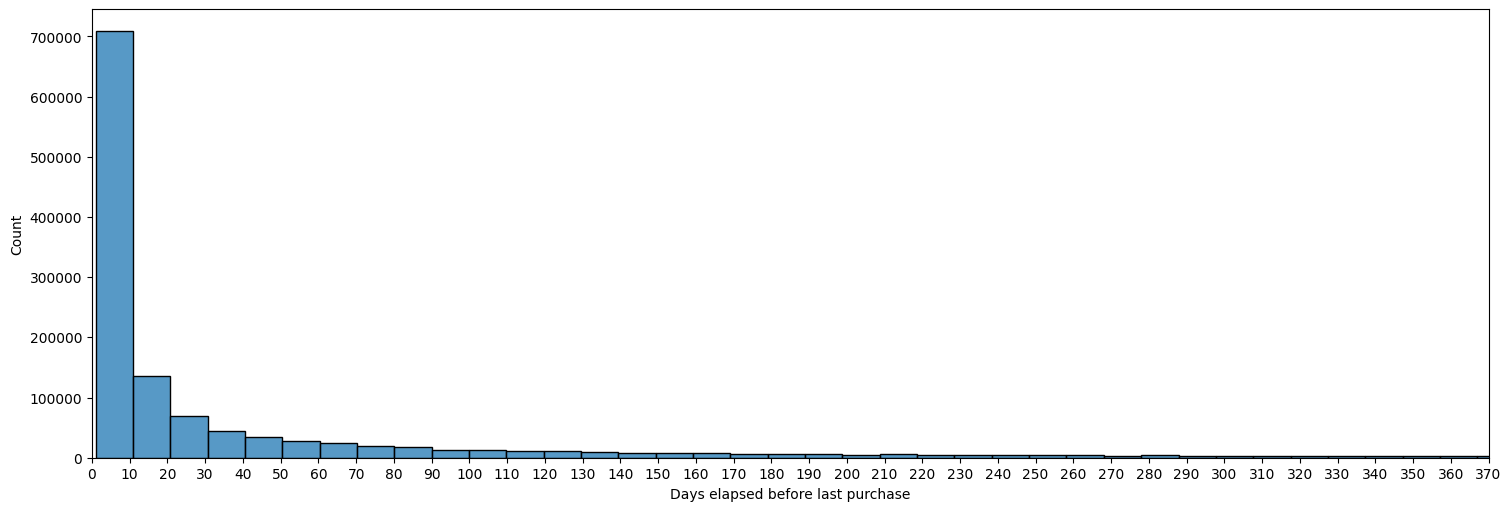

In [10]:
#H&M has a 30 days return policy. So for each transaction lets check if the item was repurchase with-in 30 of the last transaction. 
# If yes for which product type.

plt.figure(figsize = (15,5), 
           dpi = 100, 
           clear = True,
           constrained_layout =  True
           )

ax = sns.histplot(data = df_subset, x = 'time_pass_before_last_purchase', bins = 74)

ax.set_xticks(list(range(0,740,10)))
ax.set_xlim(0,370)
ax.set_xlabel("Days elapsed before last purchase")
ax.set_ylabel("Count")
plt.show()

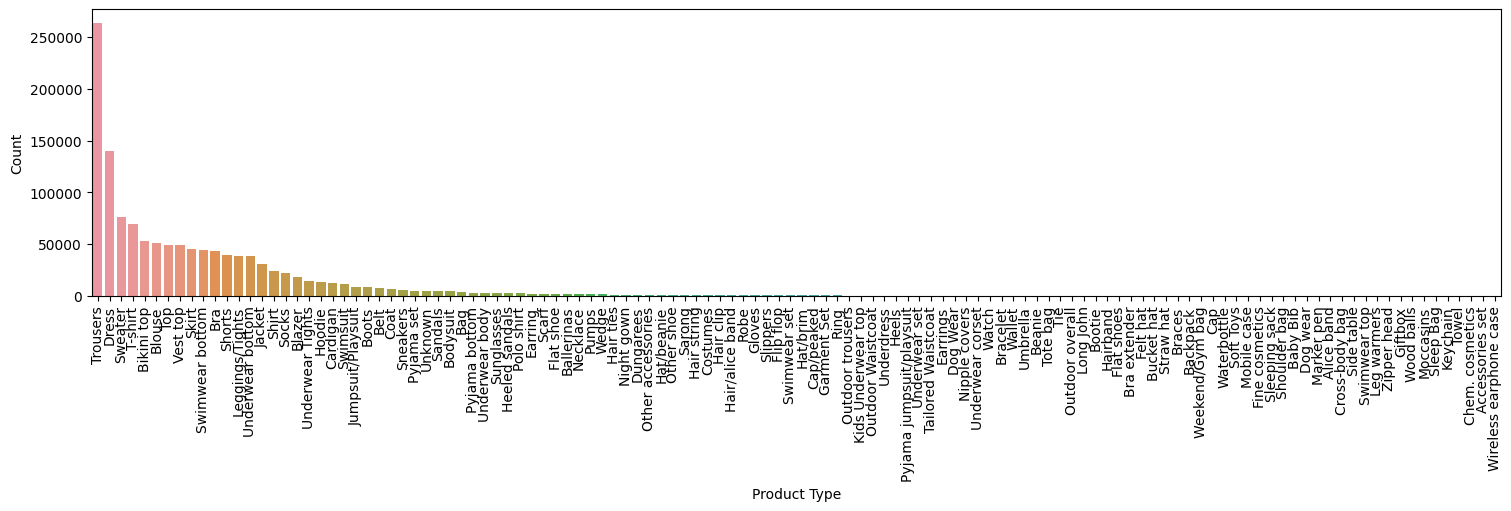

In [11]:
fig_WS = plt.figure(num = 1, 
                    figsize = (15,5), 
                    dpi = 100, 
                    clear = True,
                    constrained_layout =  True
                    )

ax = sns.countplot(data = df_subset, 
                   x = 'product_type_name',
                   order = df_subset['product_type_name'].value_counts().index
                   )

ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation = 90                   
                   )

ax.set_xlabel("Product Type")
ax.set_ylabel("Count")

plt.show()
fig_WS.clf()

In [12]:
del [df_subset]
gc.collect()

6933

##### **Observation** #####

1. It make sense that items under accessories categories like Bra, Cap, Hair Clip, Wallets, Belts etc are item that user can repurchase more then once.
2. Almost 85% of cloths that had a repurchase belong to garment categories like Trousers, Dress, Sweater, T-Shirt etc. It is mostly likely that user not purchase same items more then once. Since item with differernt colour will have different article_id. 
3. Almost 90% of the item that where repurchase where with in 30 days and H&M has 30 days return policy. 

**So we can assume that those where return and user purchase the same item in different size and H&M are tracking those item as new transaction and may be maintaing seperate table to return of the transaction.**

**Since we would like to recommend user new item that are similary to the item they have purchase in past. So we can drop these duplicate item where they have purchase same item again. We shall keep only last transaction that user made for that item.** 

In [13]:
#Delete duplicate purchase from transaction and keep the first transaction record only
df_group.sort_values(by = ['customer_id','article_id','t_dat'], inplace = True, ascending = False)
df_group.head()

,customer_id,article_id,t_dat,price,online_sale,index_col,previous_purchase,time_pass_before_last_purchase
2831516,9223333063893176977,607834005,2018-11-18,0.017776,False,2620551,2018-11-08,10
2831515,9223333063893176977,607834005,2018-11-08,0.025406,True,2265236,NaT,0
2831514,9223148401910457466,830770001,2019-12-14,0.029358,False,20126479,2019-11-08,36
2831513,9223148401910457466,830770001,2019-11-08,0.033875,False,18773300,NaT,0
2831512,9223148401910457466,767377003,2019-06-09,0.050842,False,11590886,2019-06-06,3


In [14]:

#First delete all the duplicate rows from the main tran table
df_transaction.drop(index = df_group.index_col, inplace = True)

df_group.drop_duplicates(subset = ['customer_id','article_id'], keep = 'first', inplace = True)


usecol = ['article_id', 't_dat', 'customer_id', 'price', 'online_sale'] 
df_transaction = pd.concat([df_transaction, 
                           df_group[usecol]
                           ], 
                           axis = 0)

                         
df_transaction.drop(columns = ['index_col'], 
                    axis = 1, 
                    inplace = True)

df_transaction.head()

,t_dat,customer_id,article_id,price,online_sale
1,2018-09-20,-6846340800584936,541518023,0.030487,True
2,2018-09-20,-8334631767138808638,505221004,0.015236,True
3,2018-09-20,-8334631767138808638,685687003,0.016937,True
4,2018-09-20,-8334631767138808638,685687004,0.016937,True
5,2018-09-20,-8334631767138808638,685687001,0.016937,True


In [29]:
print("Shape of transaction records after droping duplicate items purchase more then once:" + str(df_transaction.shape)) 
df_transaction.head()

Shape of transaction records after droping duplicate items purchase more then once:(27306439, 5)


,t_dat,customer_id,article_id,price,online_sale
1,2018-09-20,-6846340800584936,541518023,0.030487,True
2,2018-09-20,-8334631767138808638,505221004,0.015236,True
3,2018-09-20,-8334631767138808638,685687003,0.016937,True
4,2018-09-20,-8334631767138808638,685687004,0.016937,True
5,2018-09-20,-8334631767138808638,685687001,0.016937,True


In [30]:
max_t_date = df_transaction.t_dat.max()
min_t_date = df_transaction.t_dat.min()

print(f'Transaction records from: {min_t_date} to {max_t_date}')

Transaction records from: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


In [31]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27306439 entries, 1 to 1
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   t_dat        datetime64[ns]
 1   customer_id  int64         
 2   article_id   uint64        
 3   price        float16       
 4   online_sale  bool          
dtypes: bool(1), datetime64[ns](1), float16(1), int64(1), uint64(1)
memory usage: 911.5 MB


#### Drop Outlier records ####

Check outlier in 'price' feature with respect to item. **Why?** Each item is different and is sold at different price. So we cannot simply apply outlier on pricing column without considering the price of each items product type.

We shall group by item to find outlier in price for that item group type.

Note: Due to dynamic pricing it is likely possible that the price of certain items got sold at much higer price then other.

**Univariant Analysis of 'price' feature over online vs offline transaction**

In [32]:
online_sales = df_transaction[df_transaction.online_sale == 1]['price']
offline_sales = df_transaction[df_transaction.online_sale == 0]['price']

print("="*20 + "Online Sales" + "="*20)
print(online_sales.describe())

print("="*20 + "Offline Sales" + "="*20)
print(offline_sales.describe())

====================Online Sales====================
count    8.970159e+06
mean              NaN
std      0.000000e+00
min      1.692772e-05
25%      1.693726e-02
50%      2.540588e-02
75%      3.387451e-02
max      5.068359e-01
Name: price, dtype: float64
====================Offline Sales====================
count    3.981397e+06
mean              NaN
std      0.000000e+00
min      1.186728e-04
25%      1.354218e-02
50%      1.863098e-02
75%      3.048706e-02
max      4.221191e-01
Name: price, dtype: float64


C:\Users\smithau8\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


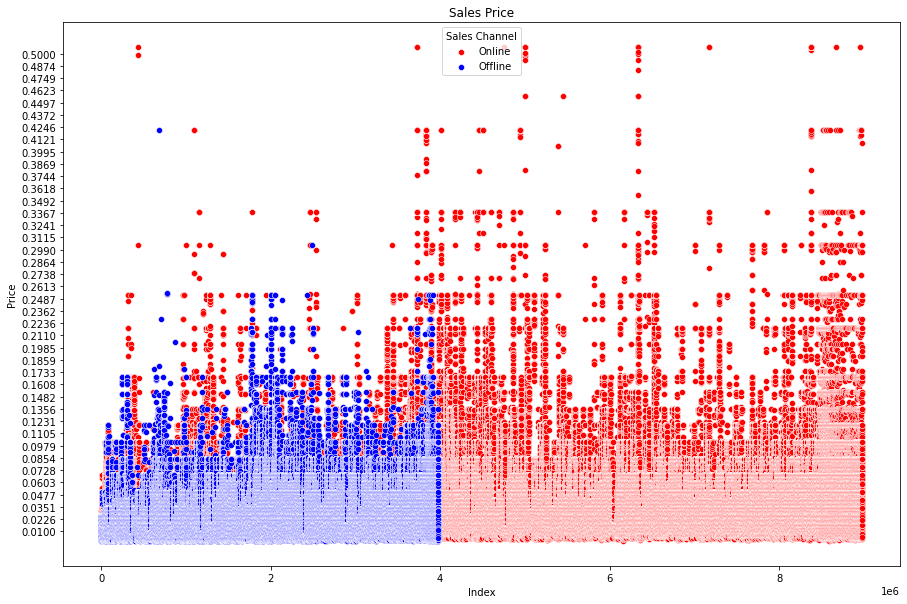

In [24]:
fig = plt.figure(figsize = (15,10))

y_index = range(online_sales.shape[0])
ax = sns.scatterplot(y = online_sales, x = y_index, color = ['red'], label = "Online")

y_index = range(offline_sales.shape[0])
ax = sns.scatterplot(y = offline_sales, x = y_index, color = ['blue'] , label = "Offline")

ax.set_title("Sales Price")
ax.set_ylabel("Price")
ax.set_xlabel("Index")
ax.set_yticks(np.linspace(0.01, 0.5, num = 40))
#ax.grid()
ax.legend(title = 'Sales Channel')

plt.show()


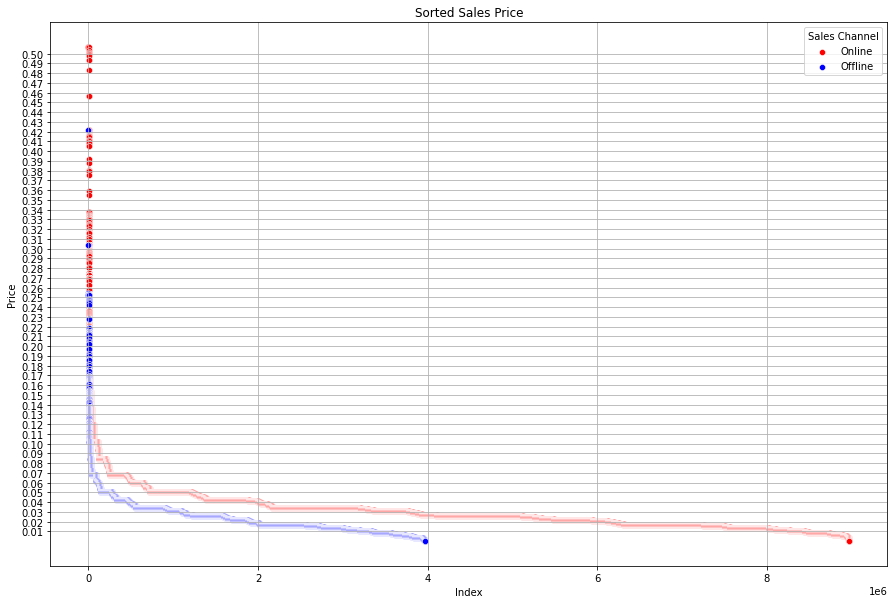

In [25]:
fig = plt.figure(figsize = (15,10))

#online_sales = df_transaction[df_transaction.online_sale == 1]['price'].values
sorted_online_price = np.sort(online_sales)[::-1]
y_index = range(online_sales.shape[0])
ax = sns.scatterplot(y = sorted_online_price, x = y_index, color = ['red'], label = "Online")


#offline_sales = df_transaction[df_transaction.online_sale == 0]['price'].values
sorted_offline_price = np.sort(offline_sales)[::-1]
y_index = range(offline_sales.shape[0])
ax = sns.scatterplot(y = sorted_offline_price, x = y_index, color = ['blue'] , label = "Offline")

ax.set_title("Sorted Sales Price")
ax.set_ylabel("Price")
ax.set_xlabel("Index")
ax.set_yticks(np.linspace(0.01, 0.5, num = 50))
ax.grid()
ax.legend(title = 'Sales Channel')

plt.show()


In [36]:
per = df_transaction[(df_transaction.price >=0.01) & (df_transaction.price<=0.17)].shape[0]
per = per/df_transaction.shape[0]
print(f'Percentage of data between [0.01, 0.17]: {per}')

per = df_transaction[(df_transaction.price > 0.17)].shape[0]
per = per/df_transaction.shape[0]
print(f'Percentage of data more then 0.17: {per}')

Percentage of data between [0.01, 0.17]: 0.9099117511440324
Percentage of data more then 0.17: 0.0008066984383961279


C:\Users\smithau8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
C:\Users\smithau8\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipy

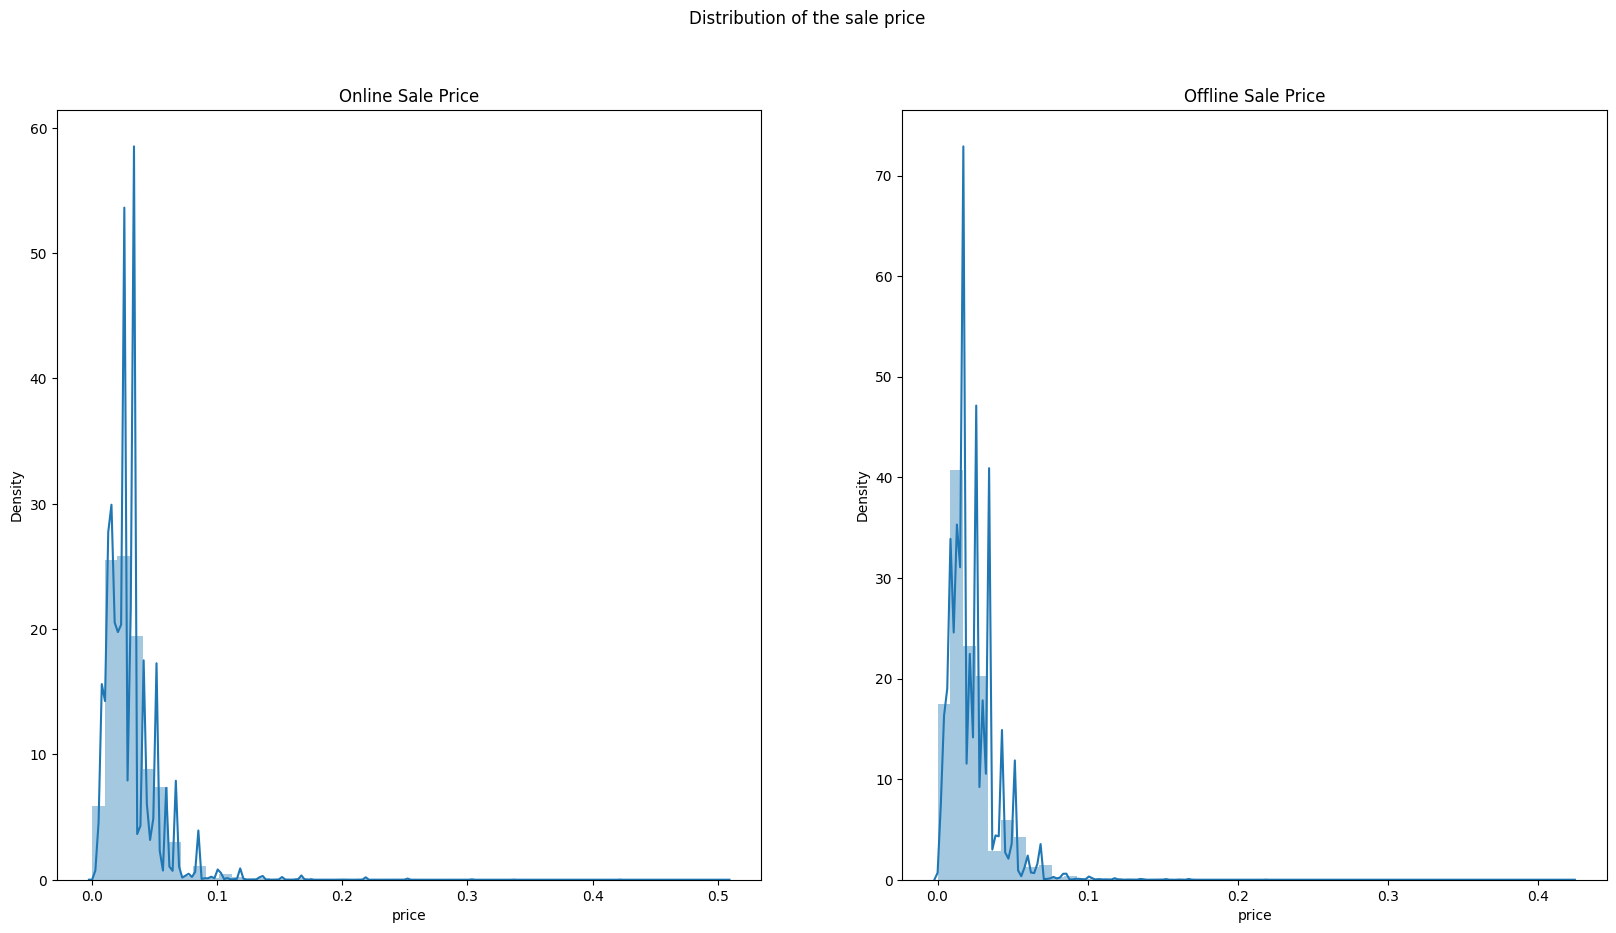

In [37]:
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
sns.distplot(online_sales, ax = axis[0])
sns.distplot(offline_sales, ax = axis[1])
plt.suptitle("Distribution of the sale price")
axis[0].set_title("Online Sale Price")
axis[1].set_title("Offline Sale Price")
plt.show()

In [39]:
from scipy.stats import  skew, kurtosis

online_sale_skewness = skew(online_sales)
online_sale_kurtosis = kurtosis(online_sales)
Offline_sale_skewness = skew(offline_sales)
Offline_sale_kurtosis = kurtosis(offline_sales)

print(f'Online Sale Price: Skewness = {online_sale_skewness}, Kurtosis = {online_sale_kurtosis} \nOffline Sale Price: Skewness = {Offline_sale_skewness}, Kurtosis = {Offline_sale_kurtosis}')

C:\Users\smithau8\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Online Sale Price: Skewness = 3.269428357593568, Kurtosis = 26.52710495963091 
Offline Sale Price: Skewness = 1.9784076840704345, Kurtosis = 8.8162238358275


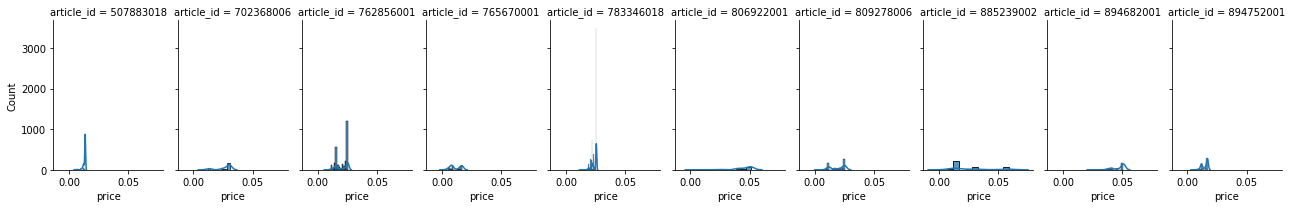

In [29]:
#Randomly sampled item to look at there distribution of each item
items = list(df_transaction.article_id.sample(n = 10, replace = False, random_state = 10))

g = sns.FacetGrid(df_transaction[df_transaction.article_id.isin(items)], col = "article_id",  aspect = 0.6) #col = 'product_type_name', height = 3.5, aspect=.65
g.map(sns.histplot, "price")
g.map(sns.kdeplot, 'price')        
plt.show()

**Observation**

1. Price of the items are in fraction and not the actual price. We might need to transfrom them that will be easier for interpret. Also items are sold at different price to different customer each day. It is possible that there was a sale on that item or price vary based on the geographical location as H&M is a global brand that sell to various countries or user applied coupon/referal point so received same item at less price.

2. Contribution of sales from offline i.e Store sales is less compare to online. 

3. There are very few records where sales price is greater then 0.04 from Offline. This could be an outlier. Will need to verify those by comparing the items sale price in both online vs offline.

4. When plot sales price is sorted order the distribution looked like Pareto Distribution where 91% of the items sold at price range between [0.01, 0.04]  

5. Distribution is highly positively skewned, where the tail on the right side of the distribution is very longer. The mean and median will be greater than the mode. We also have high kurtosis, indicating that data has heavy tails or outliers. 

6. Distribution of price per articel is also skew that make sence since any item when they are launch (i.e new in fashion) the price of the item is higher, as days pass by the item is seen as old fashion and the price of the item goes down and likely user purchase that item more. So that could be the reason that number of item sold at original price is less compare to when the price of the item goes down.


Note: kurtosis is a measure that describes the shape of a distribution's tails in relation to its overall shape. A distribution can be infinitely peaked with low kurtosis, and a distribution can be perfectly flat-topped with infinite kurtosis. For my reference https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa

**Challange:**

1. How do we determine whether that price indicates a changing market or is simply an outlier? 

2. Generally for any item when they are launch (i.e new in fashion) the price of the item is higher, as days pass by the item is seen as old fashion and the price of the item goes down to more the items out of the shelf. i.e we need to identify outlier with respect to items as well. So do we have to check both global and local outlier?

Note: 
=> For now we shall consider sale of item in both channel as same.
=> Find global outlier is called Point anomaly: Single anomalous instances in a larger dataset.
=> Find Local outlier is called Contextual anomaly: In contextual anomalies, point can be seen as normal but when a given context is taken into account, the point turns out to be an anomaly.

**Possible approachs:**

    => Z-Score will not work as the data is skewed. It works for normal distribution.
        > Since skeweness effects mean and standard deviation i.e it will pull the value towards the skewness.
        > Z-Score of a data point tell us how far away point is from the mean w.r.t the standard deviation. i.e point x is 2 standard devivation away from there mean. It can be in +ve/-ve side.
        > With Z-Score we provide threshold ie the Standard deviation, using which we consider any data point that is greater than that threshold value as outlier. So in case of Skewed distribution will not work as threshold value are consider for both +ve and -ve side

    => Using Inter Quartile Range(IQR). We will get output same as what we have seen in Boxplot. Lets check the data point where boxplot showed the items as outlier.

    => Use unsupervised algorithm to learn/find outlier data. 

We can not consider the output that model return and set it as outlier. We need to check the data point and make the call


HOW is DBSCAN different from LOF for outlier detection? Since i did not read any thing about clustering algority is can not reply.
KNN is computation expensive
So lets take LOF, Isloated Forset, CBLOF as starting point

Blog to use PYOD Library for Outlier detection
https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/
https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1


##### Inter Quaterila Range (IQR) #####

In [ ]:
Q1 = df_transaction.price.quantile(0.25)
Q3 = df_transaction.price.quantile(0.75)
IQR = Q3 - Q1

#Outlier items
df_transaction['IQR_outlier'] = df_transaction.price.apply(lambda x: True if ( ( x < (Q1 - (1.5*IQR) ) ) | ( x > ( Q3 + (1.5*IQR) ) ) ) else False)
print("Number of data points suggested as outlier: "+ str(df_transaction.IQR_outlier.sum()) )
print("Number of unique item having outlier data: " + str(df_transaction[df_transaction.IQR_outlier].article_id.nunique()) )



In [ ]:
fig  = px.scatter(df_transaction[df_transaction.article_id.isin(df_transaction[df_transaction.IQR_outlier].article_id)],
           y = "price", 
           color = 'IQR_outlier', 
           symbol = 'IQR_outlier',
           hover_data = ['IQR_outlier']
          )

fig.show()

In [ ]:
df_transaction[df_transaction.article_id.isin(df_transaction[df_transaction.IQR_outlier].article_id)].head(10)

**Observartion**

1. IQR cannot correclty classify outlier to find outlier at global level as the price of an items is 10K which is higer then other item it was treating it as outlier. Which is incorrect. 

We want to find records where the price vary with in the item range 

##### Local Outlier Factor(LOF) #####

**Observartion**

* Analysis "price" feature w.r.t features like articleId, product_id is just a numerice field that unique idently the item in the data. 
Feature like "color", "department" etc does not effect the price of an item.

* "product_type" can effect the price but that dependes e.g "product_type" type can be sold at differet price based on the style, material and other factor that effect the price of an item. 

* Observed that "product_code" is unique for each item. So will use "product_code" and mapped those "product_code" to int to see the variation of the price. Will use "channel_type" as well. As we have observed that the price of same item solved in online and offline vary. It make sence as in offline store charges are more since that have to pay for the infrastructure expense. So they can not provide more discount.

In [30]:
#Create product code mapping
rid_to_idx = {}
for (idx, rid) in enumerate(df_transaction['product_code'].unique().tolist()):
    rid_to_idx[rid] = idx
    
df_transaction['product_code_mapping'] = df_transaction['product_code'].apply(lambda x: rid_to_idx[x])

In [31]:
from sklearn.neighbors import LocalOutlierFactor

n_neighbors = 15
contamination = 0.0001

clof = LocalOutlierFactor( contamination = contamination , 
                           n_neighbors = n_neighbors
                         )

# fit the dataset to the model
#print("fit the dataset to the model...")
y_pred = clof.fit_predict(df_transaction[['price','product_code_mapping','online_sale']])

df_transaction['score'] = clof.negative_outlier_factor_
df_transaction['y_pred'] = y_pred

n_inliers =  np.count_nonzero(y_pred == 1)
n_outliers = np.count_nonzero(y_pred == -1)

print("Local OutlierFactor",'- OUTLIERS : ',n_outliers,', INLIERS : ',n_inliers)


C:\Users\smithau8\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


Local OutlierFactor - OUTLIERS :  1296 , INLIERS :  12950260


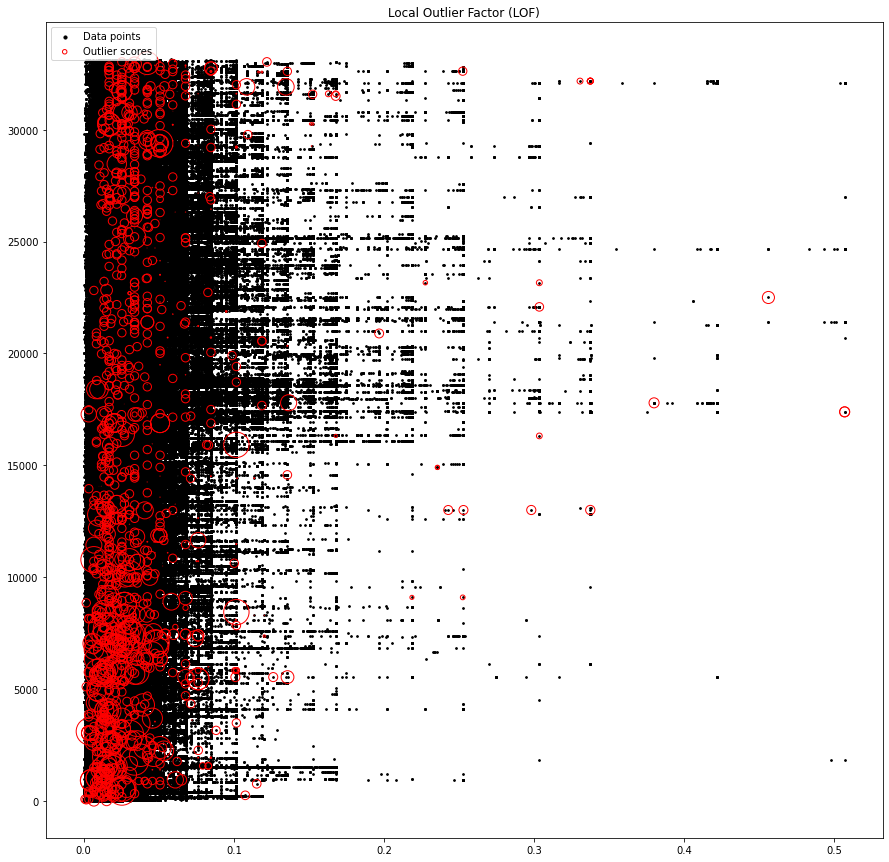

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,15))

plt.scatter(df_transaction.price,
            df_transaction.product_code_mapping, 
            color = "k", 
            s = 3.0, 
            label = "Data points")

# plot circles with radius proportional to the outlier scores

X_outlier = df_transaction[df_transaction.y_pred == -1]
X_scores = X_outlier.score
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

plt.scatter(
    X_outlier.price,
    X_outlier.product_code_mapping,
    s = 1000 * radius,
    edgecolors = "r",
    facecolors = "none",
    label = "Outlier scores",
)

plt.axis("tight")
plt.title("Local Outlier Factor (LOF)")

legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [ ]:
df_transaction.sort_values(by = 'score', ascending = False )[:10]

**Note:** 
* LOF retrun score that is continues int variable. It is difficulty to interpred which larger score is harder to interpred. Refer AI Cource viedo
* LOP is improvement of LOF where it retun value between [0,1] i.e probality of the point to be outlier
* https://towardsdatascience.com/identifying-outliers-with-local-outlier-probabilities-2b5781e86e01#:~:text=Local%20Outlier%20Probabilities%20is%20a,the%20Iris%20dataset%20for%20illustration. 
* LocalOutlierProbability: It was taking too much time even on small data set.

In [35]:
#Let's look at the data points that are reported as outlier w.r.t to the item to confirm if they are actual outlier 

total_outlier = df_transaction[(df_transaction.y_pred == -1)].article_id.values


In [36]:
df_transaction[df_transaction.article_id.isin([802431001])]

,t_dat,article_id,customer_id,price,online_sale,score,y_pred
6904311,2019-12-02,802431001,8052100413206700919,0.03558,True,-1.000052e+10,-1


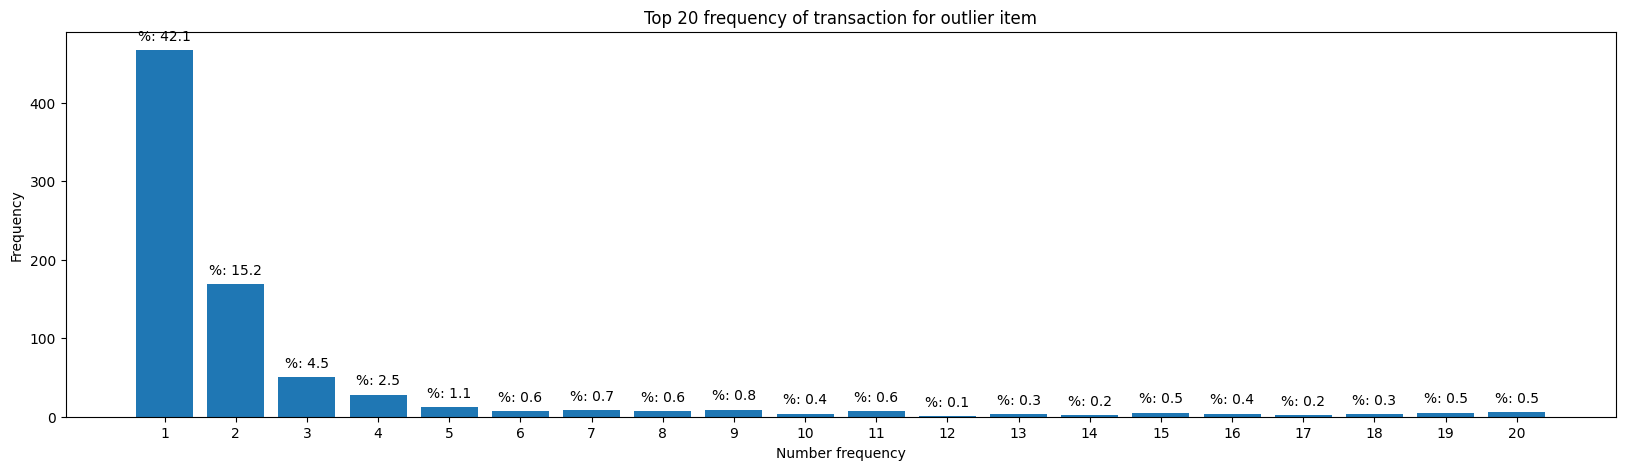

In [37]:
#Total number of transaction for outlier items. 
df_outlier_transaction = df_transaction[df_transaction.article_id.isin(total_outlier)] #Get all the transaction for the given outlier items

hlpeda.plot_frequency(df_outlier_transaction,  "article_id", 20, "transaction for outlier item")

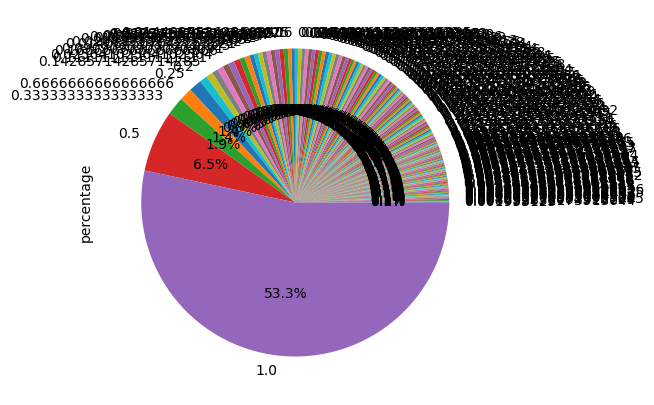

In [38]:
#https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
#https://sparkbyexamples.com/python/pandas-percentage-total-with-groupby/
#Level in groupby() is used when you have multiple indices and you want to use only one index of the DataFrame

#%Percentage of outlier detected for a given item. Will show the frequent of the item where entire trnsaction of item is conside as outlier.
#  If that is the case we can not consider that transaction as outlier.

df_outlier_per = (df_outlier_transaction
                    .groupby(['article_id','y_pred'])['y_pred']
                    .count()
                    .groupby(level = 0)
                    .transform(lambda x: x/x.sum())
                    .reset_index(name = "percentage")
                 )
                 

df_outlier_per[df_outlier_per.y_pred == -1]['percentage'].value_counts().sort_values().plot.pie(figsize=(5, 5),autopct='%1.1f%%')
df_outlier_per.sort_values(by ='percentage', inplace = True)



In [39]:
df_outlier_per['percentage'].describe()

count    1628.000000
mean        0.681818
std         0.406605
min         0.000795
25%         0.250000
50%         0.979592
75%         1.000000
max         1.000000
Name: percentage, dtype: float64

In [40]:
df_outlier_per[(df_outlier_per.y_pred == -1) & (df_outlier_per.percentage == 1)].article_id

1623    935978001
1585    926440001
1625    940483001
1604    930284001
1588    926593001
          ...    
581     713385003
582     714000001
595     716258001
1134    842072001
1627    942128001
Name: article_id, Length: 592, dtype: int64

**Observartion**
* There where data points which are consider as outlier has only one transaction made for those items.
* Number of frequency of items having only 1 to 4 contribute to approx 64% of the outlier items. This make sence as there where not enought data points for algo to check if the given data points is outlier or not.
* Almost 53.4% of item where entire transaction is treated as outlier which is incorrect.

Outlier item with only one transaction can not be consider as oulier since we do not have enough data to compare the price with other transaction. We can ignore to consider items with only 1 transaction as outlier. 

So lets check if all the transaction of the items should not be consider as outlier.

Check if customer that has purchase the outler item id with 1 transaction has made any other transaction, if not delete it. as only one transaction by the customer will not help to find the customer preference pattern.  

Number of transaction made per items is very less so its is not easy to detect outlier.

Number of transaction by customer with outlier item: 54610


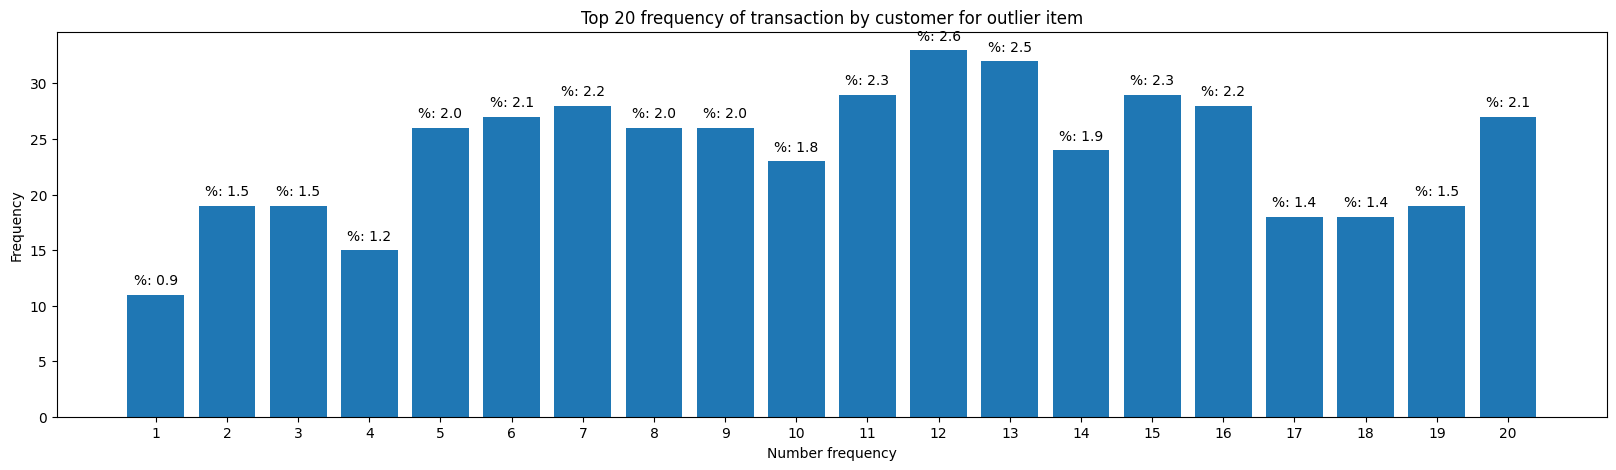

In [41]:
#Total number of transaction made by customer that include the article that are detected as outlier. If the customer has only on transaction that is describe as outlier we can removed 
customerid_outlier_items = df_outlier_transaction[df_outlier_transaction.y_pred == -1]['customer_id'].values

df_outlier_customer_transaction = df_transaction[df_transaction.customer_id.isin(customerid_outlier_items)]

print("Number of transaction by customer with outlier item: "+ str(df_outlier_customer_transaction.shape[0]))

hlpeda.plot_frequency(df_outlier_customer_transaction, "customer_id", 20, "transaction by customer for outlier item")

**Observartion**
* 1.2% of transaction by customer are items that are detected as outlier. So can drop those as this will not be helpfull to find pattern for customer.
* Even if there is only one transaction of the item, but there are customer that has made more then 1 transaction that include those item. This will give the purchase pattern of the customer.

In [42]:
grp_outlier = (df_outlier_customer_transaction
                .groupby('customer_id')['t_dat']
                .count()
                .reset_index(name = 'total_transaction')
                )

row_index = df_transaction[df_transaction.customer_id.isin(grp_outlier[grp_outlier.total_transaction == 1]['customer_id'].values)].index

df_transaction.drop(row_index, inplace = True) 


In [43]:
#Ignore the items with only 1 transaction and reported as outlier
df_transaction.y_pred = np.where(df_transaction.article_id.isin(df_outlier_transaction
                                                                .groupby('article_id')['t_dat']
                                                                .count()
                                                                .pipe(lambda  dfx: dfx.loc[dfx == 1]).index
                                                                #.reset_index(name = 'count')
                                                                ), 
                                    1, 
                                    df_transaction.y_pred
                                )

#Ignore the items where entire transaction of the item is treaded as outlier
df_transaction.y_pred = np.where(df_transaction.article_id.isin(
                                        df_outlier_per[(df_outlier_per.y_pred == -1) & (df_outlier_per.percentage == 1)].article_id.values
                                       ),
                                       1,
                                       df_transaction.y_pred
                                )

df_transaction.y_pred.value_counts()

 1    12951002
-1         543
Name: y_pred, dtype: int64

In [44]:
#Items where 50% of the transaction is consider as outlier is also not correct as it take 50% of the transaction data as outlier
df_outlier_per[(df_outlier_per.y_pred == -1) & (df_outlier_per.percentage >= 0.5)]

,article_id,y_pred,percentage
578,712052002,-1,0.5
1532,913276001,-1,0.5
511,700343001,-1,0.5
509,699925001,-1,0.5
103,541095002,-1,0.5
...,...,...,...
581,713385003,-1,1.0
582,714000001,-1,1.0
595,716258001,-1,1.0
1134,842072001,-1,1.0


In [45]:
df_transaction[df_transaction.article_id == 877608001]

,t_dat,article_id,customer_id,price,online_sale,score,y_pred
11323990,2020-08-30,877608001,-8521687632171075236,0.03387,True,-7.100967e+09,1
11323991,2020-09-04,877608001,-8425557596889940734,0.02168,True,-9.763452e+09,-1


In [46]:
df_transaction[df_transaction.article_id == 913276001]

,t_dat,article_id,customer_id,price,online_sale,score,y_pred
12152613,2020-09-17,913276001,-8897647453870898521,0.04446,False,-1.016859e+10,-1
12152614,2020-09-18,913276001,2819634444443448079,0.05930,False,-9.244731e+09,1
12152615,2020-09-21,913276001,-5488690847593071351,0.05930,False,-9.244731e+09,1
12152616,2020-09-22,913276001,-3344540453329748211,0.05377,False,-1.016890e+10,-1


In [47]:
#Items with 50% or more(i.e 60% or 75% of item are outlier) of the item consider as outlier is also incorrect as half of the transaction records is conside as outlier
df_transaction.y_pred = np.where(df_transaction.article_id.isin(
                                        df_outlier_per[(df_outlier_per.y_pred == -1) & (df_outlier_per.percentage >= 0.5)].article_id.values
                                       ),
                                       1,
                                       df_transaction.y_pred
                                )

df_transaction.y_pred.value_counts()

 1    12951113
-1         432
Name: y_pred, dtype: int64

In [48]:
df_transaction[df_transaction.article_id == 933327001]

,t_dat,article_id,customer_id,price,online_sale,score,y_pred
12329646,2020-08-20,933327001,758431248305630664,0.03207,True,-1.567584e+00,1
12329647,2020-08-20,933327001,-8477147054138916162,0.03387,True,-1.000000e+00,1
12329648,2020-08-20,933327001,-2677954301260426286,0.03387,True,-1.000000e+00,1
12329649,2020-08-21,933327001,-7505581905497456164,0.03387,True,-1.000000e+00,1
12329650,2020-08-22,933327001,-6366855383790227003,0.03387,True,-1.000000e+00,1
...,...,...,...,...,...,...,...
12927664,2020-08-28,933327001,8384883706261943876,0.03387,True,-1.000000e+00,1
12929062,2020-08-29,933327001,7497883197212183739,0.03387,True,-1.000000e+00,1
12931072,2020-08-31,933327001,-3649134240623759556,0.03387,True,-1.000000e+00,1
12934835,2020-09-03,933327001,-5320510887893725971,0.03387,True,-1.000000e+00,1


In [49]:
#Drop outlier that contribute less then 1% . We shall consider thoes as outlier
outlier_article_id = df_outlier_per[df_outlier_per.percentage < 0.1]['article_id'].values

df_transaction.drop(df_transaction[df_transaction.article_id.isin(outlier_article_id) & (df_transaction.y_pred == -1)].index,
                    inplace = True)

df_transaction.y_pred.value_counts()

 1    12951113
-1          86
Name: y_pred, dtype: int64

In [52]:
del df_transaction
gc.collect()

39175

## Article ##

In [6]:
df_article = pd.read_csv(ARTICLES_MASTER_TABLE)
print("Number of items:" + str(df_article.shape[0]))

Number of items:105542


##### Analysis of department feature #####

In [4]:
article_department = df_article.department_name.unique()

print("Number of department:" + str(len(article_department)))
print(f"List of department: {article_department}")

Number of department:250
List of department: ['Jersey Basic' 'Clean Lingerie' 'Tights basic' 'Baby basics'
 'Casual Lingerie' 'Jersey' 'EQ & Special Collections' 'Hair Accessories'
 'Other items' 'Baby Nightwear' 'Men Sport Woven' 'Men Sport Bottoms'
 'Kids Boy Denim' 'Shopbasket Socks' 'Socks' 'UW'
 'Young Girl Jersey Basic' 'Jacket Street' 'Belts' 'Divided Shoes'
 'Swimwear' 'Underwear Jersey' 'Basic 1' 'Tops Knitwear DS'
 'Men Sport Acc' 'Kids Boy Jersey Basic' 'Young Girl UW/NW' 'Shirt'
 'Nightwear' 'Trouser' 'Small Accessories' 'Sunglasses' 'Gloves/Hats'
 'Knit & Woven' 'Basics' 'Accessories' 'Jewellery' 'Jersey Fancy DS'
 'Trousers DS' 'Bags' 'Blazer S&T' 'Knitwear' 'Woven bottoms' 'Shorts'
 'Dresses DS' 'Expressive Lingerie' 'Kids Girl UW/NW'
 'Young Boy Jersey Basic' 'Kids Girl S&T' 'Young Girl S&T'
 'Shoes / Boots inactive from s5' 'Nursing' 'Jersey Fancy' 'Shoes'
 'Functional Lingerie' 'Men Sport Tops' 'Other Accessories'
 'Young Boy Trouser' 'Outdoor/Blazers DS' 'Mama Linger

In [5]:
col = ['article_id','prod_name','product_type_name','garment_group_name','product_group_name','index_group_name',  
       #Bellow is the addition colmus can be added if it helps
       'index_name','department_name'
      ]

pd.set_option('display.max_rows', None)

def analysis_item_by_department(filter_department_name, department_name, top_n_item = 10, bottom_n_item = -1, show_item_images = False):

    """
    Will get all the items with department name containing the filter word. 
    Why use department_name? Because found that it provide some more detail on the item. Like if the item is for kid for which age group the item belong to.
    """

    filter_dept_name = hlpeda.filter_types(filter_department_name, department_name)
    
    print("\nNumber of items in the filter department: "+ str(len(filter_dept_name)))
    print(f'\nFilter department: {filter_dept_name}')

   #Why don't we drop item with similar product_code and keep only one? Because even if the item vary in some patern or color, 
   # it is a different item for a user and color play an important feature for undersand the user preference in the color type

    grp_filter_dept = df_article[df_article.department_name.isin(filter_dept_name)].groupby("product_code")[col]     
    grp_filter_dept = grp_filter_dept.first() #Only take the first item of the product_code since we have many item of same code with different color have unique article_id(i.e item_id)
    
    print("\nNumber of item belong to filter department: "+ str(len(grp_filter_dept)))

    if bottom_n_item == -1:
        display(grp_filter_dept.iloc[:top_n_item])
    else:
        display(grp_filter_dept.iloc[-bottom_n_item:])

    #Show item image
    if show_item_images == True:
        if bottom_n_item == -1:
            items = grp_filter_dept.article_id[:top_n_item]
        else:
            items = grp_filter_dept.article_id[-bottom_n_item:]

        items = items.reset_index(drop = True)
        hlpimage.show_item_img(items, figsiz = (25, 35))

    return filter_dept_name

#print(filter_types(['Jersey'], article_department))
#analysis_item_by_department(['Jersey'], article_department)

In [6]:
print("\nAnalysis Jersey department")

jercy_departments = analysis_item_by_department(['Jersey'], 
                                                article_department, 
                                                top_n_item = 20, 
                                                show_item_images = hlpimage.SHOW_ITEMS_IMAGE
                                               )


Analysis Jersey department

Number of items in the filter department: 27

Filter department: ['Jersey Basic', 'Jersey', 'Young Girl Jersey Basic', 'Underwear Jersey', 'Kids Boy Jersey Basic', 'Jersey Fancy DS', 'Young Boy Jersey Basic', 'Jersey Fancy', 'Kids Girl Jersey Basic', 'Jersey inactive from s1', 'Projects Jersey & Knitwear', 'Jersey License', 'Light Basic Jersey', 'Jersey fancy', 'Baby Girl Jersey Fancy', 'Kids Girl Jersey Fancy', 'Tops Fancy Jersey', 'Kids Boy Jersey Fancy', 'Young Girl Jersey Fancy', 'Young Boy Jersey Fancy', 'Jersey/Knitwear Premium', 'Jersey Occasion', 'Baby Boy Jersey Fancy', 'Underwear Jersey Fancy inactive from s1', 'Heavy Basic Jersey', 'AK Tops Jersey & Woven', 'Jersey inactive from S.6']

Number of item belong to filter department: 8810


,article_id,prod_name,product_type_name,garment_group_name,product_group_name,index_group_name,index_name,department_name
product_code,,,,,,,,
108775,108775015,Strap top,Vest top,Jersey Basic,Garment Upper body,Ladieswear,Ladieswear,Jersey Basic
116379,116379047,Frugan longsleeve,Top,Jersey Basic,Garment Upper body,Ladieswear,Ladieswear,Jersey Basic
118458,118458003,Jerry jogger bottoms,Trousers,Jersey Basic,Garment Lower body,Menswear,Menswear,Jersey Basic
120129,120129001,Babette long,Leggings/Tights,Jersey Fancy,Garment Lower body,Ladieswear,Ladieswear,Jersey
129085,129085001,Pirate Leggings (1),Leggings/Tights,Jersey Basic,Garment Lower body,Ladieswear,Ladieswear,Jersey Basic
163734,163734002,KOMPIS 2-pack L/S,Top,Jersey Basic,Garment Upper body,Baby/Children,Children Sizes 134-170,Young Girl Jersey Basic
179123,179123001,Long Leggings,Leggings/Tights,Jersey Basic,Garment Lower body,Ladieswear,Ladieswear,Jersey Basic
184583,184583014,Robin 3pk solid,Underwear bottom,"Under-, Nightwear",Underwear,Menswear,Menswear,Underwear Jersey
186372,186372011,Harem trousers,Trousers,Jersey Basic,Garment Lower body,Ladieswear,Ladieswear,Jersey Basic


In [7]:
#Lets look at specify type of Jercy type item to under are they same or differnet from Jercy basic and Jercy Fancy
Jercy_department = ['Jersey inactive from s1','Projects Jersey & Knitwear','Jersey License', 'Light Basic Jersey',
                  'Tops Fancy Jersey','Jersey/Knitwear Premium','Jersey Occasion','Underwear Jersey Fancy inactive from s1', 
                  'Heavy Basic Jersey', 'AK Tops Jersey & Woven', 'Jersey inactive from S.6']

analysis_item_by_department(Jercy_department,
                            article_department, 
                            show_item_images = hlpimage.SHOW_ITEMS_IMAGE)


Number of items in the filter department: 11

Filter department: ['Jersey inactive from s1', 'Projects Jersey & Knitwear', 'Jersey License', 'Light Basic Jersey', 'Tops Fancy Jersey', 'Jersey/Knitwear Premium', 'Jersey Occasion', 'Underwear Jersey Fancy inactive from s1', 'Heavy Basic Jersey', 'AK Tops Jersey & Woven', 'Jersey inactive from S.6']

Number of item belong to filter department: 1307


,article_id,prod_name,product_type_name,garment_group_name,product_group_name,index_group_name,index_name,department_name
product_code,,,,,,,,
366686,366686001,Tail tee,T-shirt,Jersey Fancy,Garment Upper body,Menswear,Menswear,Jersey inactive from s1
405586,405586006,Volly jumper (1),Sweater,Jersey Fancy,Garment Upper body,Divided,Divided,Projects Jersey & Knitwear
409683,409683006,Verona Tank,Vest top,Jersey Fancy,Garment Upper body,Divided,Divided,Projects Jersey & Knitwear
409730,409730006,Granada tank,Vest top,Jersey Fancy,Garment Upper body,Divided,Divided,Projects Jersey & Knitwear
409731,409731006,Cornell ss jumper,T-shirt,Jersey Fancy,Garment Upper body,Divided,Divided,Projects Jersey & Knitwear
410624,410624005,Mitch top,T-shirt,Jersey Fancy,Garment Upper body,Divided,Divided,Projects Jersey & Knitwear
424022,424022011,Annabel V neck,T-shirt,Jersey Fancy,Garment Upper body,Ladieswear,Ladieswear,Jersey License
424511,424511007,Swift jumper,Sweater,Jersey Fancy,Garment Upper body,Divided,Divided,Projects Jersey & Knitwear
425639,425639003,Luwin knit jumper,Sweater,Jersey Fancy,Garment Upper body,Divided,Divided,Projects Jersey & Knitwear


['Jersey inactive from s1',
 'Projects Jersey & Knitwear',
 'Jersey License',
 'Light Basic Jersey',
 'Tops Fancy Jersey',
 'Jersey/Knitwear Premium',
 'Jersey Occasion',
 'Underwear Jersey Fancy inactive from s1',
 'Heavy Basic Jersey',
 'AK Tops Jersey & Woven',
 'Jersey inactive from S.6']

In [8]:
Jercy_department = ['Jersey inactive from s1','Jersey License', 'Light Basic Jersey',
                     'Jersey Occasion','Underwear Jersey Fancy inactive from s1', 
                     'Jersey inactive from S.6']

analysis_item_by_department(Jercy_department,
                            article_department, 
                            show_item_images = hlpimage.SHOW_ITEMS_IMAGE)


Number of items in the filter department: 6

Filter department: ['Jersey inactive from s1', 'Jersey License', 'Light Basic Jersey', 'Jersey Occasion', 'Underwear Jersey Fancy inactive from s1', 'Jersey inactive from S.6']

Number of item belong to filter department: 328


,article_id,prod_name,product_type_name,garment_group_name,product_group_name,index_group_name,index_name,department_name
product_code,,,,,,,,
366686,366686001,Tail tee,T-shirt,Jersey Fancy,Garment Upper body,Menswear,Menswear,Jersey inactive from s1
424022,424022011,Annabel V neck,T-shirt,Jersey Fancy,Garment Upper body,Ladieswear,Ladieswear,Jersey License
443262,443262014,Frank Tank,Vest top,Jersey Basic,Garment Upper body,Menswear,Menswear,Light Basic Jersey
449263,449263003,Zero Tee,T-shirt,Jersey Fancy,Garment Upper body,Menswear,Menswear,Jersey inactive from s1
450780,450780006,Washed Hoodie (1),Sweater,Jersey Fancy,Garment Upper body,Menswear,Menswear,Jersey inactive from s1
452898,452898020,MARION-SHORTS,Shorts,Jersey Basic,Garment Lower body,Menswear,Menswear,Light Basic Jersey
459428,459428001,Jerry Hood,Jacket,Jersey Fancy,Garment Upper body,Menswear,Menswear,Jersey inactive from s1
485052,485052002,Drop Cutoff,Vest top,Jersey Fancy,Garment Upper body,Menswear,Menswear,Jersey inactive from s1
504960,504960001,Pocket tanktop,Vest top,Jersey Fancy,Garment Upper body,Menswear,Menswear,Jersey inactive from s1


['Jersey inactive from s1',
 'Jersey License',
 'Light Basic Jersey',
 'Jersey Occasion',
 'Underwear Jersey Fancy inactive from s1',
 'Jersey inactive from S.6']

In [9]:
print("\nAnalysis socks department")

socks_department = ['socks', 'sock']
socks_departments = analysis_item_by_department(socks_department, 
                                                article_department, 
                                                show_item_images = hlpimage.SHOW_ITEMS_IMAGE)


Analysis socks department

Number of items in the filter department: 14

Filter department: ['Shopbasket Socks', 'Shopbasket Socks', 'Socks', 'Socks', 'Socks Bin', 'Socks Bin', 'Baby Socks', 'Baby Socks', 'Kids Boy Socks', 'Kids Boy Socks', 'Young Boy Socks', 'Young Boy Socks', 'Socks Wall', 'Socks Wall']

Number of item belong to filter department: 392


,article_id,prod_name,product_type_name,garment_group_name,product_group_name,index_group_name,index_name,department_name
product_code,,,,,,,,
160442,160442007,3p Sneaker Socks,Socks,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Shopbasket Socks
164912,164912035,Scallop 5p Socks,Socks,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Shopbasket Socks
179393,179393001,Basic 2p Overknee,Socks,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Socks
190021,190021001,Basic 5p Minishaftless,Socks,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Shopbasket Socks
217727,217727002,Polly 3p minishaftless,Socks,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Socks
226959,226959007,Astaire 1p Overknee,Socks,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Socks
243937,243937001,Straight Edge 5p Socks,Socks,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Shopbasket Socks
265630,265630004,Invisible 3p minishaftless,Socks,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Socks
266873,266873001,Micro 2p minishaftless,Socks,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Socks


In [10]:
print("\nAnalysis bra department")

bra_department = ['bra', 'bras', 'Lingerie']
bra_departments = analysis_item_by_department(bra_department, 
                                              article_department, 
                                              show_item_images = hlpimage.SHOW_ITEMS_IMAGE)


Analysis bra department

Number of items in the filter department: 8

Filter department: ['Clean Lingerie', 'Casual Lingerie', 'Expressive Lingerie', 'Functional Lingerie', 'Mama Lingerie', 'Ladies Sport Bras', 'Ladies Sport Bras', 'Shopbasket Lingerie']

Number of item belong to filter department: 1869


,article_id,prod_name,product_type_name,garment_group_name,product_group_name,index_group_name,index_name,department_name
product_code,,,,,,,,
110065,110065001,OP T-shirt (Idro),Bra,"Under-, Nightwear",Underwear,Ladieswear,Lingeries/Tights,Clean Lingerie
114428,114428026,Alice BANDEAU 2-p,Bra,"Under-, Nightwear",Underwear,Ladieswear,Lingeries/Tights,Casual Lingerie
153115,153115019,OP Strapless^,Bra,"Under-, Nightwear",Underwear,Ladieswear,Lingeries/Tights,Clean Lingerie
253448,253448001,OP Push Melbourne^,Bra,"Under-, Nightwear",Underwear,Ladieswear,Lingeries/Tights,Clean Lingerie
278811,278811002,Hilly Biker 2pk LT,Underwear bottom,"Under-, Nightwear",Underwear,Ladieswear,Lingeries/Tights,Functional Lingerie
280256,280256001,Mirage Push,Bra,"Under-, Nightwear",Underwear,Ladieswear,Lingeries/Tights,Expressive Lingerie
283532,283532005,Hanny Padded bra E&F,Bra,"Under-, Nightwear",Underwear,Ladieswear,Lingeries/Tights,Functional Lingerie
286536,286536007,Layla Push,Bra,"Under-, Nightwear",Underwear,Ladieswear,Lingeries/Tights,Expressive Lingerie
301213,301213001,Tilda clean padded bra (1),Bra,"Under-, Nightwear",Underwear,Ladieswear,Lingeries/Tights,Mama Lingerie


In [11]:
print("\nAnalysis shoe department")

shoe_department = ['Sneakers', 'shoe', 'shoes', 'Boots', 'boot']
shoe_departments = analysis_item_by_department(shoe_department, 
                                               article_department, 
                                               show_item_images = hlpimage.SHOW_ITEMS_IMAGE)


Analysis shoe department

Number of items in the filter department: 25

Filter department: ['Divided Shoes', 'Divided Shoes', 'Shoes / Boots inactive from s5', 'Shoes / Boots inactive from s5', 'Shoes / Boots inactive from s5', 'Shoes / Boots inactive from s5', 'Shoes', 'Shoes', 'Sneakers small girl inactive from s2', 'Boots', 'Boots', 'Sneakers', 'Shoes Other', 'Shoes Other', 'Kids Boy Shoes', 'Kids Boy Shoes', 'Young Boy Shoes', 'Young Boy Shoes', 'Kids Girl Shoes', 'Kids Girl Shoes', 'Sneakers big girl inactive from s2', 'Baby Shoes', 'Baby Shoes', 'Young Girl Shoes', 'Young Girl Shoes']

Number of item belong to filter department: 1968


,article_id,prod_name,product_type_name,garment_group_name,product_group_name,index_group_name,index_name,department_name
product_code,,,,,,,,
181160,181160009,Eva chelsea boot,Boots,Shoes,Shoes,Divided,Divided,Divided Shoes
212042,212042036,Mimmi sneaker,Sneakers,Shoes,Shoes,Divided,Divided,Divided Shoes
258650,258650001,Berlin boot,Boots,Shoes,Shoes,Divided,Divided,Divided Shoes
264713,264713001,Al Car Shoe,Other shoe,Shoes,Shoes,Menswear,Menswear,Shoes / Boots inactive from s5
278563,278563001,Harris cross sandal PQ,Sandals,Shoes,Shoes,Menswear,Menswear,Shoes
319906,319906001,Steve Slipper,Slippers,Shoes,Shoes,Menswear,Menswear,Shoes
320880,320880001,JOAN SUEDE BOOT,Boots,Shoes,Shoes,Divided,Divided,Divided Shoes
331072,331072001,Kobe boot,Boots,Shoes,Shoes,Menswear,Menswear,Shoes / Boots inactive from s5
349301,349301010,GLASSIG ESPADRILLE,Ballerinas,Shoes,Shoes,Divided,Divided,Divided Shoes


In [12]:
print("\nAnalysis children/baby department")

children_department = ['kids', 'kid', 'baby', 'newborn', 'boy', 'girl', 'boys', 'girls']
children_departments = analysis_item_by_department(children_department, 
                                                   article_department, 
                                                   show_item_images = hlpimage.SHOW_ITEMS_IMAGE)


Analysis children/baby department

Number of items in the filter department: 165

Filter department: ['Baby basics', 'Baby Nightwear', 'Kids Boy Denim', 'Kids Boy Denim', 'Kids Boy Denim', 'Young Girl Jersey Basic', 'Kids Boy Jersey Basic', 'Kids Boy Jersey Basic', 'Kids Boy Jersey Basic', 'Young Girl UW/NW', 'Kids Girl UW/NW', 'Kids Girl UW/NW', 'Kids Girl UW/NW', 'Young Boy Jersey Basic', 'Kids Girl S&T', 'Kids Girl S&T', 'Kids Girl S&T', 'Young Girl S&T', 'Young Boy Trouser', 'Young Boy Denim', 'Kids Girl Jersey Basic', 'Kids Girl Jersey Basic', 'Kids Girl Jersey Basic', 'Baby Socks', 'Young Boy Shirt', 'Kids Girl Big Acc', 'Kids Girl Big Acc', 'Kids Girl Big Acc', 'Young Girl Denim', 'Baby Toys/Acc', 'Young Girl Knitwear', 'Baby Boy Outdoor', 'Baby Boy Outdoor', 'Newborn', 'Young Boy UW/NW', 'Kids Boy Socks', 'Kids Boy Socks', 'Kids Boy Socks', 'Young Boy Socks', 'Kids Girl Swimwear', 'Kids Girl Swimwear', 'Kids Girl Swimwear', 'Young Girl Swimwear', 'Baby Boy Woven', 'Baby Boy Wo

,article_id,prod_name,product_type_name,garment_group_name,product_group_name,index_group_name,index_name,department_name
product_code,,,,,,,,
112679,112679048,SWEATSHIRT OC,Sweater,Jersey Basic,Garment Upper body,Baby/Children,Baby Sizes 50-98,Baby basics
141661,141661022,Velour pyjama,Pyjama jumpsuit/playsuit,"Under-, Nightwear",Nightwear,Baby/Children,Baby Sizes 50-98,Baby Nightwear
146706,146706001,Tanktop body white 3PACK,Bodysuit,Jersey Basic,Garment Upper body,Baby/Children,Baby Sizes 50-98,Baby basics
147339,147339034,6P SS BODY,Bodysuit,Jersey Basic,Garment Upper body,Baby/Children,Baby Sizes 50-98,Baby basics
156289,156289011,Slim Cheapo 79,Trousers,Trousers Denim,Garment Lower body,Baby/Children,Children Sizes 92-140,Kids Boy Denim
163734,163734002,KOMPIS 2-pack L/S,Top,Jersey Basic,Garment Upper body,Baby/Children,Children Sizes 134-170,Young Girl Jersey Basic
174057,174057022,FLEECE PYJAMA,Pyjama jumpsuit/playsuit,"Under-, Nightwear",Nightwear,Baby/Children,Baby Sizes 50-98,Baby Nightwear
176550,176550016,Sleep bag padded,Sleep Bag,"Under-, Nightwear",Underwear/nightwear,Baby/Children,Baby Sizes 50-98,Baby Nightwear
187949,187949016,Padded pyjama,Pyjama jumpsuit/playsuit,"Under-, Nightwear",Nightwear,Baby/Children,Baby Sizes 50-98,Baby Nightwear


In [13]:
print("\nAnalysis children/baby department detail")

children_department = ['Kids Boy Shorts', 'Young Girl Shoes', 'Baby Boy Jersey Fancy', 'Baby Girl Knitwear']
analysis_item_by_department(children_department, 
                            article_department, 
                            show_item_images = hlpimage.SHOW_ITEMS_IMAGE)


Analysis children/baby department detail

Number of items in the filter department: 4

Filter department: ['Baby Girl Knitwear', 'Baby Boy Jersey Fancy', 'Young Girl Shoes', 'Kids Boy Shorts']

Number of item belong to filter department: 805


,article_id,prod_name,product_type_name,garment_group_name,product_group_name,index_group_name,index_name,department_name
product_code,,,,,,,,
506491,506491001,MEYA dress,Dress,Knitwear,Garment Full body,Baby/Children,Baby Sizes 50-98,Baby Girl Knitwear
506494,506494001,BECKY romper,Jumpsuit/Playsuit,Knitwear,Garment Full body,Baby/Children,Baby Sizes 50-98,Baby Girl Knitwear
506515,506515003,HONOLULU,Leggings/Tights,Knitwear,Garment Lower body,Baby/Children,Baby Sizes 50-98,Baby Girl Knitwear
506528,506528002,DELLI jaquard sweater,Sweater,Knitwear,Garment Upper body,Baby/Children,Baby Sizes 50-98,Baby Girl Knitwear
506621,506621001,EVA jaquard cardigan,Cardigan,Knitwear,Garment Upper body,Baby/Children,Baby Sizes 50-98,Baby Girl Knitwear
515748,515748004,Olle t-shirt,T-shirt,Jersey Fancy,Garment Upper body,Baby/Children,Baby Sizes 50-98,Baby Boy Jersey Fancy
519145,519145005,Tempest,Trousers,Jersey Fancy,Garment Lower body,Baby/Children,Baby Sizes 50-98,Baby Boy Jersey Fancy
526434,526434009,Roger Sweater,Sweater,Jersey Fancy,Garment Upper body,Baby/Children,Baby Sizes 50-98,Baby Boy Jersey Fancy
542917,542917001,Tage Sweater,Sweater,Jersey Fancy,Garment Upper body,Baby/Children,Baby Sizes 50-98,Baby Boy Jersey Fancy


['Baby Girl Knitwear',
 'Baby Boy Jersey Fancy',
 'Young Girl Shoes',
 'Kids Boy Shorts']

In [14]:
print("\nAnalysis bag department")

bag_department = ['bag', 'bags']
bag_departments = analysis_item_by_department(bag_department, 
                                              article_department, 
                                              show_item_images = hlpimage.SHOW_ITEMS_IMAGE)


Analysis bag department

Number of items in the filter department: 10

Filter department: ['Bags', 'Bags', 'Bags & Items', 'Bags & Items', 'Small Bags', 'Small Bags', 'Boys Small Acc & Bags', 'Boys Small Acc & Bags', 'Girls Small Acc/Bags', 'Girls Small Acc/Bags']

Number of item belong to filter department: 1201


,article_id,prod_name,product_type_name,garment_group_name,product_group_name,index_group_name,index_name,department_name
product_code,,,,,,,,
241436,241436001,Fix it tote bag,Bag,Accessories,Accessories,Ladieswear,Ladies Accessories,Bags
289834,289834016,FANTASTIC SHOPPER,Bag,Accessories,Accessories,Divided,Divided,Bags
360295,360295023,Kardashian shopper,Bag,Accessories,Accessories,Divided,Divided,Bags
382468,382468007,Backpack Oliver,Bag,Accessories,Accessories,Menswear,Menswear,Bags & Items
386678,386678001,Big Arjuna crossbag,Bag,Accessories,Accessories,Ladieswear,Ladies Accessories,Bags
386681,386681012,Mini Cross Bag,Bag,Accessories,Accessories,Ladieswear,Ladies Accessories,Bags
386695,386695004,Penny leather cross,Bag,Accessories,Accessories,Ladieswear,Ladies Accessories,Small Bags
387444,387444006,Petit cross bag (1),Bag,Accessories,Accessories,Ladieswear,Ladies Accessories,Small Bags
388573,388573002,Wera western belt,Belt,Accessories,Accessories,Divided,Divided,Bags


In [15]:
other_departments = list(set(article_department) - 
                          set(jercy_departments) - 
                          set(bra_departments) - 
                          set(shoe_departments) - 
                          set(children_departments) - 
                          set(socks_departments) - 
                          set(bag_departments)
                         )

other_departments = analysis_item_by_department(other_departments, 
                                                article_department, 
                                                top_n_item = 20 ,
                                                show_item_images = hlpimage.SHOW_ITEMS_IMAGE)


Number of items in the filter department: 272

Filter department: ['Tights basic', 'Baby basics', 'EQ & Special Collections', 'EQ & Special Collections', 'Hair Accessories', 'Hair Accessories', 'Other items', 'Baby Nightwear', 'Men Sport Woven', 'Men Sport Woven', 'Men Sport Bottoms', 'Men Sport Bottoms', 'UW', 'Jacket Street', 'Jacket Street', 'Belts', 'Swimwear', 'Basic 1', 'Tops Knitwear DS', 'Tops Knitwear DS', 'Tops Knitwear DS', 'Men Sport Acc', 'Young Girl UW/NW', 'Shirt', 'Nightwear', 'Trouser', 'Small Accessories', 'Small Accessories', 'Sunglasses', 'Gloves/Hats', 'Knit & Woven', 'Knit & Woven', 'Basics', 'Accessories', 'Jewellery', 'Trousers DS', 'Trousers DS', 'Trousers DS', 'Blazer S&T', 'Blazer S&T', 'Knitwear', 'Woven bottoms', 'Woven bottoms', 'Woven bottoms', 'Shorts', 'Dresses DS', 'Dresses DS', 'Dresses DS', 'Kids Girl UW/NW', 'Nursing', 'Men Sport Tops', 'Other Accessories', 'Other Accessories', 'Young Boy Trouser', 'Outdoor/Blazers DS', 'Outdoor/Blazers DS', 'Outdo

,article_id,prod_name,product_type_name,garment_group_name,product_group_name,index_group_name,index_name,department_name
product_code,,,,,,,,
111565,111565001,20 den 1p Stockings,Underwear Tights,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Tights basic
111586,111586001,Shape Up 30 den 1p Tights,Leggings/Tights,Socks and Tights,Garment Lower body,Ladieswear,Lingeries/Tights,Tights basic
111593,111593001,Support 40 den 1p Tights,Underwear Tights,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Tights basic
111609,111609001,200 den 1p Tights,Underwear Tights,Socks and Tights,Socks & Tights,Ladieswear,Lingeries/Tights,Tights basic
112679,112679048,SWEATSHIRT OC,Sweater,Jersey Basic,Garment Upper body,Baby/Children,Baby Sizes 50-98,Baby basics
123173,123173001,Control Top 50 den 1p Tights,Leggings/Tights,Socks and Tights,Garment Lower body,Ladieswear,Lingeries/Tights,Tights basic
126589,126589006,2p Claw,Hair clip,Accessories,Accessories,Ladieswear,Ladies Accessories,EQ & Special Collections
130035,130035001,Black Umbrella,Umbrella,Accessories,Items,Ladieswear,Ladies Accessories,Other items
141661,141661022,Velour pyjama,Pyjama jumpsuit/playsuit,"Under-, Nightwear",Nightwear,Baby/Children,Baby Sizes 50-98,Baby Nightwear


**Observation**

1. We should drop item where "department_name" contain "inactive". e.g "Jersey inactive from s1", "Jersey inactive from S.6" , "Underwear Jersey Fancy inactive from s1" etc

2. Can we remove the word "Garment" from "product_group_name"? No since there are other items like shoe care, Accessories. Word "garment" clarify that the item is an clothing item.

3. drop article_id 0925656001, 0617835001 from database as image is not clearly visible.

4. "department_name" for children specify for which gender the items is for. So we can use them for item for children catagory e.g Young Girl, Young Boy. Also children size is the age group of the children.

5. In some case "department_name" provide additional information of the product e.g Sweater as Knitwear

6. “Divided” catagory is a teenage collection which is suitable for all body types and skin tones, you can see various colors and hues with it. They are made for teens who are trying to get the vintage, classy and cute look or the sophisticated ones too. Filter all "Divided" item and they are mix item that can be wore either by ladies and mens wear. Some clothes can be wore by both i.e unisex. It will be difficult to find a pattern in the name or the try to classify them in either of the two catagory. Looking at random images of the type we can assumne that they belong to Ladieswear Catagory. But we can not be sure.

7. product_type 'bar' under Menswear which is incorrect. When checking the image found that they where thermal clothing for menswear. We might need to remove such entires but its difficult to trace an fix them with right.

8. replace "Socks & Tights" to "Socks" if department_name contain "socks" else "Tights"

9. most of the "Socks" items where in pair.

10. for "Under-, Nightwear" under "bra" item can be replace with "product_group_name" as it clearly tell if the item is nightwear or underwear.

11. UW: Underwear, NW: Nightwear, S&T: Socks and Tights

12. Socks "index_name" is "Lingeries/Tights" is not correct.

13. Should be drop article/items that does not contribute much to over all sales? No 

14. Jersey Basic and Fancy are same. In Jersey Fancy cloths have some pattern drawn over them.

15. Some basic understanding of "Jersey" items
    - Heavy Basic Jersey to Jersey
    - Jersey Basic to Jersey
    - Jersey Fancy to Jersey Fancy
    - Jersey fancy to Jersey Fancy
    - Jercy Fancy and Jercy Fancy DS same.  
    - Heavy Basic Jersey to Jersey Heavy
    - Jersey/Knitwear Premium to Jersey Knitwear
    - Tops Fancy Jersey to Jersey Fancy. Because Garment Lower Body is a way tell it for "Top"
    - Projects Jersey & Knitwear to Jersey Knitwear 
    - Jersey License to Jersey Fancy
    - AK Tops Jersey & Woven to Jersey Fancy
    - Light Basic Jersey to Jersey
    - Underwear Jersey to Jersey Underwear

16. We should consider product_type instead of product_name. Because when new item get added to cataglog the type will remain the same i.e. either that are skits, shoes, accesories , trouses , upper/lower body part etc. But name can be any thing. So it will be easier. Beside we will use the image embedding to get the much details of the item. 

Conclusion: 
- In some case department_name feature provide some added details to the items.
- At time of feature engineering will use garment_group_name such that it include details of the catagory 

           garment_group_name =  index_group_name + index_name + department_name

Let's clean items based on department_name

#### Analysis of product type name feature ####

In [16]:
unique_product_type = df_article.product_type_name.unique()
print(f'Unique product_type_name:{unique_product_type}')

Unique product_type_name:['Vest top' 'Bra' 'Underwear Tights' 'Socks' 'Leggings/Tights' 'Sweater'
 'Top' 'Trousers' 'Hair clip' 'Umbrella' 'Pyjama jumpsuit/playsuit'
 'Bodysuit' 'Hair string' 'Unknown' 'Hoodie' 'Sleep Bag' 'Hair/alice band'
 'Belt' 'Boots' 'Bikini top' 'Swimwear bottom' 'Underwear bottom'
 'Swimsuit' 'Skirt' 'T-shirt' 'Dress' 'Hat/beanie' 'Kids Underwear top'
 'Shorts' 'Shirt' 'Cap/peaked' 'Pyjama set' 'Sneakers' 'Sunglasses'
 'Cardigan' 'Gloves' 'Earring' 'Bag' 'Blazer' 'Other shoe'
 'Jumpsuit/Playsuit' 'Sandals' 'Jacket' 'Costumes' 'Robe' 'Scarf' 'Coat'
 'Other accessories' 'Polo shirt' 'Slippers' 'Night gown' 'Alice band'
 'Straw hat' 'Hat/brim' 'Tailored Waistcoat' 'Necklace' 'Ballerinas' 'Tie'
 'Pyjama bottom' 'Felt hat' 'Bracelet' 'Blouse' 'Outdoor overall' 'Watch'
 'Underwear body' 'Beanie' 'Giftbox' 'Sleeping sack' 'Dungarees'
 'Outdoor trousers' 'Wallet' 'Swimwear set' 'Swimwear top' 'Flat shoe'
 'Garment Set' 'Ring' 'Waterbottle' 'Wedge' 'Long John'
 'Outdoor

In [17]:

def random_view_items_per_product_group(filters,  no_sample = 2):
    
    flt = hlpeda.filter_types(filters, unique_product_type)
    df = (df_article[df_article.product_type_name.isin(flt)]
          .groupby(by = 'product_type_name')['article_id']
          .apply(lambda s: s.sample(no_sample, replace = True) )
          .reset_index())

    if hlpimage.SHOW_ITEMS_IMAGE == True:
        items = df.article_id
        hlpimage.show_item_img(items,2)
    else:
        print('='*150)
        display(df_article[df_article.article_id.isin(df.article_id)])

In [ ]:
#Check image for each type to better understand the items

#Check item type "Hat", "Cap"
random_view_items_per_product_group(["Hat", "Cap"])

#Check item type "hair"
random_view_items_per_product_group(["hair"])

#Check item type "glasses"
random_view_items_per_product_group(["glasses"], no_sample = 5)

#Check item type "Toys"
random_view_items_per_product_group(["toy"])

#Check item type "Shoe"
random_view_items_per_product_group(["Shoe","Sandel"])

#What are Ballerinas product type
random_view_items_per_product_group(["Ballerinas"])

#What are Dungarees product type
random_view_items_per_product_group(["Dungarees"])

#What are Beanie covers product type
random_view_items_per_product_group(["Beanie"])
#It look like some kind of hat 

#What are Sarong covers product type
random_view_items_per_product_group(["Sarong"])
#Looks like a beach wear

#What are Giftbox product type
random_view_items_per_product_group(["Giftbox"])

#What are Side table product type
random_view_items_per_product_group(["Side table"])
#Its Laundary cleaning items

#What are Wood balls product type
random_view_items_per_product_group(["Wood balls"])

#What are Braces product type
random_view_items_per_product_group(["Braces"])
#Have see similary item in Other Accesories

#What are Nipple covers product type. #Not sure which catagory should be tag them
random_view_items_per_product_group(["Nipple covers"])

#What are Wedge product type
random_view_items_per_product_group(["Wedge"])
#This can come under scandel catagory

#What are "Zipper head" product type
random_view_items_per_product_group(["Zipper head"])

#What are "Pumps" product type
random_view_items_per_product_group(["Pumps"])
#Its a type of scandel

#What are "Slippers" product type
random_view_items_per_product_group(["Slippers"])

#What are "Underdress" product type
random_view_items_per_product_group(["Underdress"])

#What are "Clothing mist" product type
random_view_items_per_product_group(["Clothing mist"])

#What are "Long John" product type
random_view_items_per_product_group(["Long John"])
#Its a type of Long underwear, also called long johns or thermal underwear, is a style of two-piece underwear with long legs and long sleeves that is normally worn during cold weather. 
#It is commonly worn by people under their clothes in cold countries.

#What are "Leg warmers" product type
random_view_items_per_product_group(["Leg warmers"])
#Leg warmers can be thought of socks

#What are "Chem. cosmetics" product type
random_view_items_per_product_group(["Chem. cosmetics"])
#Chem: means Chemical based cosmetics

#Need to properly catagories them to segemnts. Lets move these to image classification problem or drop these
random_view_items_per_product_group(["Garment set"])

In [ ]:
#Need to properly catagories them to segment. 
#Example there was artile 714985001,705143001 belong to glove catagory. 
#Once we train the image classifcation we can run the classifcation on the Other Accesories
random_view_items_per_product_group(["Other accessories"], no_sample = 15)

**Observartion:**

1. There are multiple type for same kind of catagory. like hat, shoes, hair accessories. We can group them to once 
2. Certain class has only one item. We can discard product type which has only 1 item after we group similar item to single product type
3. Handel "Unknown" value in "product_type_name"
    - One possible learning approach is to build image classification model to assign value where product_type_name is "Unknown". Once we have type of the item,  we can fill the value for "garment_group_name", "product_group_name" based on the product_type_name learned
    - Drop the rows where product_type_name in "Unknown"


### Clean metadata information of article ###

#### Drop product_type_name = "Unknown" ####

In [19]:
# Lets drop the data row where "product_type_name" = "Unknown".
# We could have run some image classification problem to predict the product_type. But number of with "Unknown" type is 121. 
# It did not make sence to train and run a model these small missing items 

print("Number of items in article master before drop: " + str(df_article.shape[0]))

df_article.drop(df_article[df_article.product_type_name == "Unknown"].index, 
                inplace = True, 
                axis = 0)

print("Number of items in article master after drop: " + str(df_article.shape[0]))

Number of items in article master before drop: 105542
Number of items in article master after drop: 105421


#### Group similar product_type_name #### 

To reduce cardinality in number of unique product type name we have.
Steps:
1. Create a new column "product_type_name_org" and copy the orignal value and update "product_type_name".
2. Group product based on the catagory they belong to

In [20]:
# Merge similar product type to single product type. 
# Here goal is the group the product type which are similar type to general type

unique_product_type = df_article.product_type_name.unique()

print(f'Number of unique product type before: {len(unique_product_type)}')

colname = 'product_type_name_org'
colindex = ['product_type_name']
#Copy the original value to new column "_org"
df_article[colname] = df_article.product_type_name


#Merge all product type of "hat" ,"cap", "Beanie" as "Hat Cap"
#Beanie look like some kind of hat
filters = ["Hat", "Cap","Beanie"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Hat Cap"

#Merge all product type of "Wood balls","Side table" etc as "Cloths Care "
filters = ["Wood balls","Side table", "Stain remover spray","Sewing kit", "Clothing mist", "Zipper head"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Cloths Care"

#Merge all product type of "Wood balls","Side table" as "Cloths Care "
filters = ["Ring", "Necklace", "Bracelet", "Earring"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Jewellery"

#Merge all product type of "Polo shirt" as "Shirt"
filters = ["Polo shirt"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Shirt"

#Merge all product type of "Bag" as "Bag"
filters = ["Bag", 'Backpack']
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Bag"

#Merge all product type like "Swimwear bottom","Swimsuit","Bikini top" as "Swimwear"
filters = ["Swimwear"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Swimwear"

#Merge all product type like "Underwear bottom","Underwear Tights","Underwear body", "Long John" as "Underwear"
filters = ["Underwear", "Long John"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Underwear"

#Merge all product type like "Hair","Alice band", "Hairband" as "Hair Accessories"
filters = ["Hair", "Alice band", "Hairband"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Hair Accessories"

#Merge all product type like "Sandals","Heeled sandals","Wedge","Pumps", "Slippers" as "Sandals"
#Ballerinas type of scandel that are used for ballerine performance
filters = ["Sandals", "Heels", "Flip flop", "Wedge", "Pump", "Slipper", "Ballerinas"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex]= "Sandals"

#Merge all product type like "Toy","Soft Toys" as "Toys"
filters = ["Toy"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Toy"

#Merge all product type like "Flat Shoe","Other Shoe","Boots", "Sneakers" as "shoe"
filters = ["shoe","Boot", "Leg warmer", "Sneakers"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Shoe"

#Merge all product type like "Dog wear" as "Dog wear"
filters = ["Dog wear"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Dog wear"

#Merge all product type like "Sunglasses","EyeGlasses" as "Glasses"
filters = ["glasses"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Glasses"

#Merge all product type like "Cosmetics","Chem. Cosmetics" as "Cosmetics" 
filters = ["Cosmetics"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Cosmetics"

#Merge all product type like "earphone case","case" as "Mobile Accesories" 
filters = ["earphone case", "case"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Mobile Accesories"

#Merge all product type like "Bra extender" as "Bra" 
filters = ["Bra extender"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Bra"

#Merge all product type like "Nipple covers" not under Nightwear department_name as "Bar"
filters = ["Nipple covers"]
rowindex = df_article[(df_article.department_name != 'Nightwear') & 
                      (df_article.product_type_name.isin(filters))].index.tolist()
df_article.loc[rowindex, colindex] = "Bra"


#Merge all product type like "Tailored Waistcoat","Outdoor Waistcoat" as "Waistcoat" 
filters = ["Waistcoat"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Waistcoat"

#Product type like "Outdoor trousers" as "trousers" 
filters = ["Outdoor trousers"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Trousers"

#UnderDress are wore along with some Dress. 
#So lets group them with Dress segment as if user has purchase and dress in past they might need underdress to wore along with it
filters = ["Underdress"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "Dress"

#Product type like "Towel","Blanket","Cushion","Waterbottle","Robe" as "trousers" 
filters = ["Towel","Blanket","Cushion","Waterbottle","Robe"]
items = hlpeda.filter_types(filters, unique_product_type)
rowindex = df_article[df_article.product_type_name.isin(items)].index.tolist()
df_article.loc[rowindex, colindex] = "House Accesories"


print(f'Number of new unique product type after: {df_article.product_type_name.nunique()}')

Number of unique product type before: 130
Number of new unique product type after: 66


<AxesSubplot:>

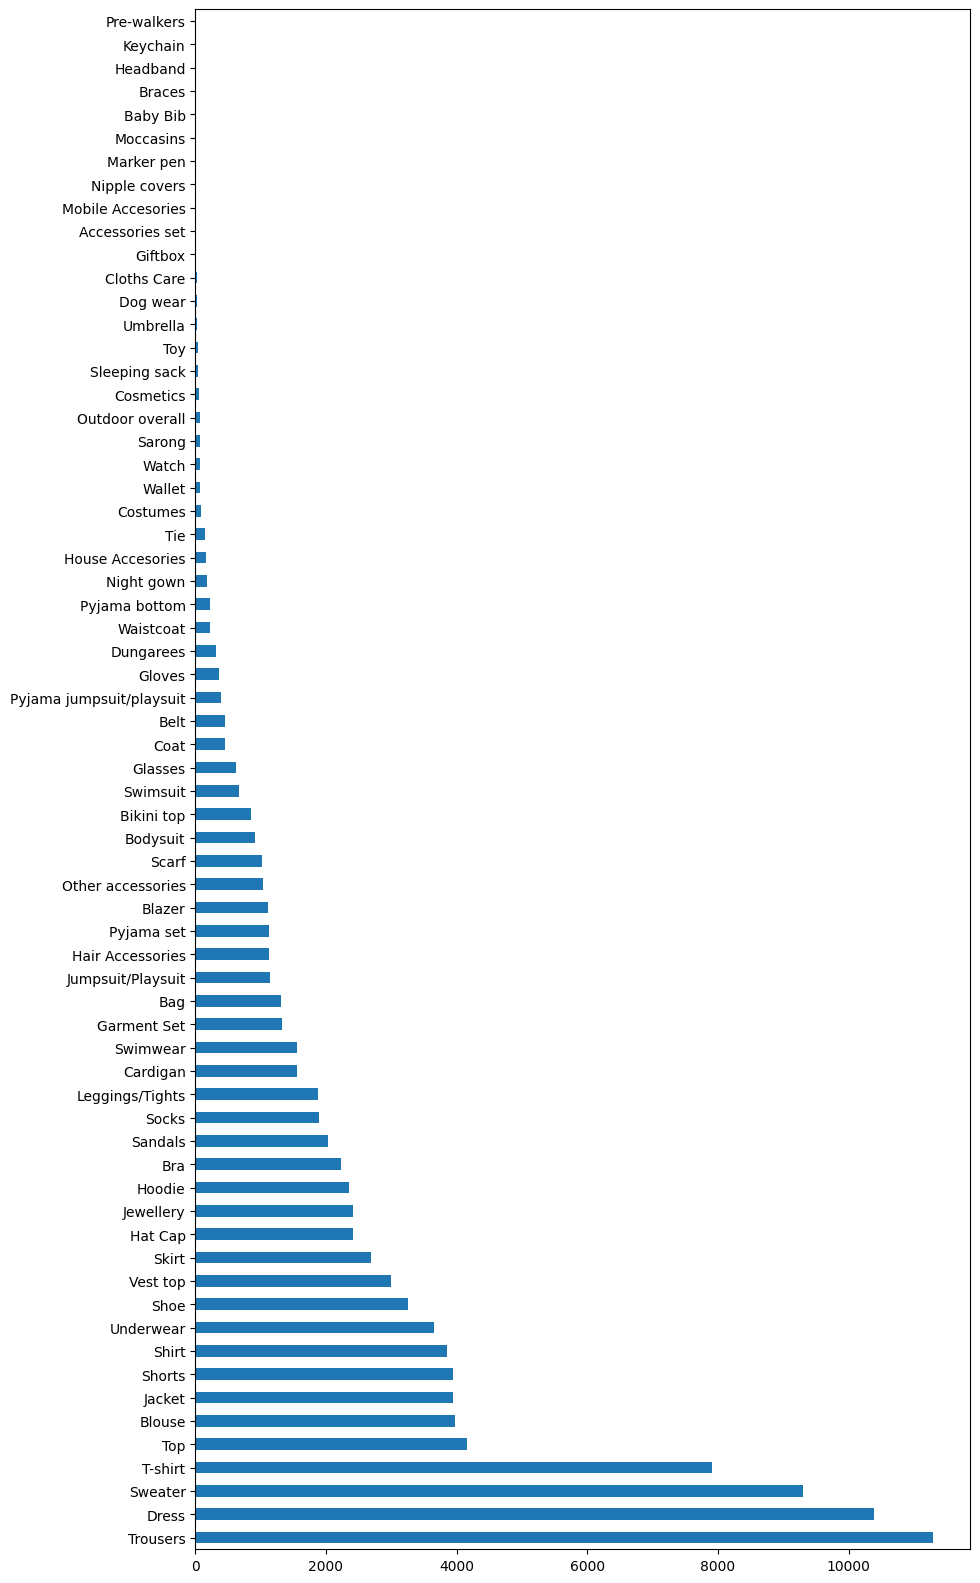

In [21]:
#Check number of images we have per class label i.e do we have balance dataset for each class
class_label_cnt = df_article.product_type_name.value_counts()
#class_label_cnt
fig = plt.figure(figsize = (10,20))
class_label_cnt.plot.barh()

In [22]:
#Discard items where type has only 5 items
threshold = 5
df_article = df_article[~df_article.product_type_name.isin(class_label_cnt[class_label_cnt <= threshold].index)]

print(f'Number of unique product type after: {df_article.product_type_name.nunique()}')

Number of unique product type after: 58


#### Clean department_name ####

In [23]:
unique_article_department = df_article.department_name.unique()

##### Remove all the item/article with the word "inactive" from the department_name. Since thoes item are not longer available #####

In [24]:
print("Number of items in article master before drop: " + str(df_article.shape[0]))

drop_departments =  df_article[df_article.department_name.isin(hlpeda.filter_types(['inactive'], unique_article_department))].index
df_article.drop(drop_departments, inplace = True)

print("Number of items in article master after drop: " + str(df_article.shape[0]))


Number of items in article master before drop: 105398
Number of items in article master after drop: 104658


##### Rename department_name = "Tights basic" to "Tights" #####

In [25]:
colindex = ['department_name']
filters = ["Tights basic"]
rowindex = df_article[df_article.department_name.isin(filters)].index.tolist()
df_article.loc[rowindex, colindex] = "Tights"

In [26]:
unique_article_department = df_article.department_name.unique()

##### Under "index_name" replace "Socks & Tights"  to "Socks" if department_name contain "Socks" else "Tights" #####

In [27]:
#Replace "index_name" feature based on department_name. i.e if department_name == "Socks" then Socks else if department_name == "Tights" the  "Tights"
#                       "Lingeries/Tights" -> Socks 
#                       "Lingeries/Tights" -> Tights 
#Since we are going to merge these column to one. And in certain case index_name provide more detail then department

colindex = ['index_name']  
filters = ["Socks"]
items = hlpeda.filter_types(filters, unique_article_department)
rowindex = df_article[df_article.department_name.isin(items)].index.tolist()
df_article.loc[rowindex,colindex] = "Socks"

colindex = ['index_name']  
filters = ["Tights"]
items = hlpeda.filter_types(filters, unique_article_department)
rowindex = df_article[df_article.department_name.isin(items)].index.tolist()
df_article.loc[rowindex,colindex] = "Tights"

df_article.index_name.unique()

array(['Ladieswear', 'Lingeries/Tights', 'Tights', 'Baby Sizes 50-98',
       'Menswear', 'Ladies Accessories', 'Sport', 'Children Sizes 92-140',
       'Socks', 'Divided', 'Children Sizes 134-170',
       'Children Accessories, Swimwear'], dtype=object)

##### Replace department_name to meaning full #####  
 
* Replace "S&T" in department_name as "Socks"
* Replace "Acc" in department_name as "Accessories"
* Replace "Accessories Other" , "Other Accessories" in department_name as "Accessories"
* Rename all "Jersey Basic" and other similar type in department_name to "Jersey"

In [28]:
#Replace "S&T" in department_name as "Socks"
colindex = ['department_name']  
filters = ["S&T"]
items = hlpeda.filter_types(filters, unique_article_department)
rowindex = df_article[df_article.department_name.isin(items)].index.tolist()
df_article.loc[rowindex,colindex] = df_article.loc[rowindex,colindex].apply(lambda x: x.replace("S&T","Socks",regex = True))


#Replace "Acc" in department_name as "Accessories"
colindex = ['department_name']  
filters = ["Acc"]
items = hlpeda.filter_types(filters, unique_article_department)
rowindex = df_article[df_article.department_name.isin(items)].index.tolist()
df_article.loc[rowindex,colindex] = df_article.loc[rowindex,colindex].apply(lambda x: x.replace("Acc","Accessories",regex = True))

#Replace "Accessories Other" , "Other Accessories" in department_name as "Accessories"
colindex = ['department_name']  
filters = ["Accessories Other", "Other Accessories"]
items = hlpeda.filter_types(filters, unique_article_department)
rowindex = df_article[df_article.department_name.isin(items)].index.tolist()
df_article.loc[rowindex,colindex] = "Accessories Other"


#Rename all "Jersey Basic" and other similar type in department_name to "Jersey"
colindex = ['department_name']
filters = ["Jersey Basic","Heavy Basic Jersey","Light Basic Jersey" ]
rowindex = df_article[df_article.department_name.isin(filters)].index.tolist()
df_article.loc[rowindex,colindex] = "Jersey"

filters = ["Jersey Fancy", "Jersey fancy","Jercy Fancy DS", "Tops Fancy Jersey", "Jersey License" ,"AK Tops Jersey & Woven"]
rowindex = df_article[df_article.department_name.isin(filters)].index.tolist()
df_article.loc[rowindex,colindex] = "Jersey Fancy"

filters = ["Heavy Basic Jersey"]
rowindex = df_article[df_article.department_name.isin(filters)].index.tolist()
df_article.loc[rowindex,colindex] = "Jersey Heavy"

filters = ["Jersey/Knitwear Premium", "Projects Jersey & Knitwear"]
rowindex = df_article[df_article.department_name.isin(filters)].index.tolist()
df_article.loc[rowindex,colindex] = "Jersey Knitwear"

filters = ["Underwear Jersey"]
rowindex = df_article[df_article.department_name.isin(filters)].index.tolist()
df_article.loc[rowindex,colindex] = "Jersey Underwear"

##### Remove the word "DS" from department_name #####

In [29]:
#Lets look at item where we have "DS" in the department name and lets understand what that mean

colindex = ['department_name']  
filter_DS = []
filter_word = "DS"
for name in unique_article_department:
    if filter_word in name:
        filter_DS = filter_DS + [name]
     
    
display(df_article[df_article.department_name.isin(filter_DS)]
        [['article_id','garment_group_name',
          'index_group_name','index_name',
          'department_name','product_type_name']].head(6)
       )

if hlpimage.SHOW_ITEMS_IMAGE == True:
    hlpimage.show_item_img(df_article[df_article.department_name.isin(filter_DS)][:6].article_id)

,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name
204,192460006,Knitwear,Divided,Divided,Tops Knitwear DS,Dress
304,216081011,Knitwear,Divided,Divided,Tops Knitwear DS,Cardigan
430,241412034,Jersey Fancy,Divided,Divided,Jersey Fancy DS,Leggings/Tights
431,241412037,Jersey Fancy,Divided,Divided,Jersey Fancy DS,Leggings/Tights
432,241412038,Trousers,Divided,Divided,Trousers DS,Leggings/Tights
433,241412043,Trousers,Divided,Divided,Trousers DS,Leggings/Tights


In [30]:
#Lets remove "DS" from department_name
rowindex = (df_article[df_article.department_name.isin(filter_DS)].index.tolist())
df_article.loc[rowindex,colindex] = df_article.loc[rowindex,colindex].apply(lambda x: x.replace("DS","",regex = True))

##### Remove UW/NW from department_name #####

In [31]:
#"UW/NW" is either "Underwear" or "Nightwear" or Just remove that if those detail is available in index_name , index_group_name

colindex = ['department_name']  
filters = ["UW/NW"]
items = hlpeda.filter_types(filters, unique_article_department)
display(df_article[df_article.department_name.isin(items)]
                  [['article_id','garment_group_name',
                    'index_group_name','index_name',
                    'department_name','product_type_name']].head(10))
#train_tran.department_name.unique()

,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name
217,198518010,"Under-, Nightwear",Baby/Children,Children Sizes 134-170,Young Girl UW/NW,Underwear
218,198518017,"Under-, Nightwear",Baby/Children,Children Sizes 134-170,Young Girl UW/NW,Underwear
219,198518020,"Under-, Nightwear",Baby/Children,Children Sizes 134-170,Young Girl UW/NW,Underwear
220,198518023,"Under-, Nightwear",Baby/Children,Children Sizes 134-170,Young Girl UW/NW,Underwear
221,198518031,"Under-, Nightwear",Baby/Children,Children Sizes 134-170,Young Girl UW/NW,Underwear
543,257430026,"Under-, Nightwear",Baby/Children,Children Sizes 92-140,Kids Girl UW/NW,Vest top
544,257430027,"Under-, Nightwear",Baby/Children,Children Sizes 92-140,Kids Girl UW/NW,Vest top
545,257430029,"Under-, Nightwear",Baby/Children,Children Sizes 92-140,Kids Girl UW/NW,Vest top
546,257430030,"Under-, Nightwear",Baby/Children,Children Sizes 92-140,Kids Girl UW/NW,Vest top
547,257430032,"Under-, Nightwear",Baby/Children,Children Sizes 92-140,Kids Girl UW/NW,Vest top


In [32]:
(df_article[(df_article.department_name.isin(items)) & 
            (df_article.product_type_name != "Underwear")
            ].product_type_name.unique())

array(['Vest top', 'Pyjama set', 'House Accesories',
       'Pyjama jumpsuit/playsuit', 'Pyjama bottom', 'Night gown'],
      dtype=object)

In [33]:
#Lets Replace department_name which contain "UW/NW" based on the product_type_name. 
#For product_type_name = "Underwear" lets remove the word "UW/NW" since we are going to merge these columne it will reflect the item
colindex = ['department_name']  
filters = ["UW/NW"]
items = hlpeda.filter_types(filters, unique_article_department)
rowindex = (df_article[(df_article.department_name.isin(items)) &
                       (df_article.product_type_name == "Underwear")
                      ].index.tolist())
df_article.loc[rowindex,colindex] = df_article.loc[rowindex,colindex].apply(lambda x: x.replace("UW/NW", "", regex = True))

#For product_type_name != "Underwear" rename the "UW/NW" = "Nightwear"
rowindex = (df_article[(df_article.department_name.isin(items)) &
                       (df_article.product_type_name != "Underwear")
                      ].index.tolist())

df_article.loc[rowindex,colindex] = df_article.loc[rowindex,colindex].apply(lambda x: x.replace("UW/NW", "Nightwear", regex = True))

##### Rename UW from department_name to Underwear #####

In [34]:
display(df_article[df_article.department_name.isin(['UW'])]
                  [['article_id','garment_group_name',
                    'index_group_name','index_name',
                    'department_name','product_type_name']].head(10))

,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name
78,162074062,"Under-, Nightwear",Divided,Divided,UW,Socks
79,162074069,"Under-, Nightwear",Divided,Divided,UW,Socks
80,162074071,"Under-, Nightwear",Divided,Divided,UW,Socks
125,181448022,"Under-, Nightwear",Divided,Divided,UW,Socks
126,181448102,"Under-, Nightwear",Divided,Divided,UW,Socks
127,181448103,"Under-, Nightwear",Divided,Divided,UW,Socks
128,181448104,"Under-, Nightwear",Divided,Divided,UW,Socks
129,181448105,"Under-, Nightwear",Divided,Divided,UW,Socks
130,181448106,"Under-, Nightwear",Divided,Divided,UW,Socks
131,181448109,"Under-, Nightwear",Divided,Divided,UW,Socks


In [35]:
df_article[df_article.department_name.isin(['UW'])].product_type_name.unique()

array(['Socks', 'Underwear', 'Bra'], dtype=object)

In [36]:
display(df_article[(df_article.product_type_name.isin(['Bra'])) 
                    & (df_article.department_name.isin(['UW']))
                    ]                  
                  [['article_id','garment_group_name',
                    'index_group_name','index_name',
                    'department_name','product_type_name']].tail(10))

,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name
11948,550833002,"Under-, Nightwear",Divided,Divided,UW,Bra
23419,605091003,"Under-, Nightwear",Divided,Divided,UW,Bra
23420,605091004,"Under-, Nightwear",Divided,Divided,UW,Bra
23421,605091005,"Under-, Nightwear",Divided,Divided,UW,Bra
71425,763862001,"Under-, Nightwear",Divided,Divided,UW,Bra
71426,763862002,"Under-, Nightwear",Divided,Divided,UW,Bra
71427,763862004,"Under-, Nightwear",Divided,Divided,UW,Bra
101679,898439001,"Under-, Nightwear",Divided,Divided,UW,Bra
101680,898439002,"Under-, Nightwear",Divided,Divided,UW,Bra
101681,898439003,"Under-, Nightwear",Divided,Divided,UW,Bra


In [37]:
colindex = ['department_name']  
rowindex = df_article[df_article.department_name == 'UW'].index.tolist()
df_article.loc[rowindex, colindex] = df_article.loc[rowindex, colindex].apply(lambda x: x.replace("UW", "Underwear", regex = True))

#### Clean "index_name" based on the value of "department_name" ####

In [38]:
#Replace index_name = "Lingeries" where department_name contain = "Lingerie"
colindex = ['index_name']  
filters = ["Lingerie"]
items = hlpeda.filter_types(filters, unique_article_department)
rowindex = df_article[df_article.department_name.isin(items)].index.tolist()
df_article.loc[rowindex,colindex] = "Lingerie"

In [39]:
#Let's check the item under Lingeries/Tights index_name
display(df_article[df_article.index_name == 'Lingeries/Tights']
         [['article_id','garment_group_name',
            'index_group_name','index_name',
            'department_name','product_type_name']]
        [-5:]
       )

,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name
104619,925124001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Pyjama set
104714,926325001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,House Accesories
105098,932698001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,House Accesories
105234,935356001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Bra
105477,943879001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Night gown


In [40]:
#Lets check items belong under Department_name  = "Nightwear"

display(df_article[df_article.department_name == 'Nightwear']
                [['article_id','garment_group_name',
                    'index_group_name','index_name',
                    'department_name','product_type_name']]
 .tail(10)
)

print("="*100)
print("Unique product type name under Nightwear department")
display(df_article[df_article.department_name == 'Nightwear'].product_type_name.unique())

,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name
104581,924623003,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Pyjama set
104582,924623004,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Pyjama set
104583,924625001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Pyjama bottom
104584,924626001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Pyjama set
104585,924642001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Pyjama set
104619,925124001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Pyjama set
104714,926325001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,House Accesories
105098,932698001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,House Accesories
105234,935356001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Bra
105477,943879001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Night gown


Unique product type name under Nightwear department


array(['Pyjama set', 'House Accesories', 'Night gown', 'Pyjama bottom',
       'Bra', 'Pyjama jumpsuit/playsuit'], dtype=object)

In [41]:
#Is an item with product_type_name as "Bra", "Nipple covers" in "Nightwear" department_name. 

#Lets first look at product_type_name = "Nipple covers"
#But the image of the item shows looks like some bags

display(df_article[(df_article.department_name == 'Nightwear') & 
                   (df_article.product_type_name.isin(['Nipple covers']))]
                    [['article_id','garment_group_name',
                        'index_group_name','index_name',
                        'department_name','product_type_name']]
       )

print("="*100)
if hlpimage.SHOW_ITEMS_IMAGE == True:
    hlpimage.show_item_img(df_article[(df_article.department_name == 'Nightwear') & 
                             (df_article.product_type_name.isin(['Nipple covers']))
                            ].article_id[-10:])

#Since we merge "Nipple covers" with Bra catagory

,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name


In [42]:
#Lets drop the item where product_type_name = "Nipple covers" in department_name = "Nightwear"  and index_name = "Lingeries/Tights" 
#As item image does not match the item description
df_article.drop(df_article[(df_article.department_name == 'Nightwear') & 
                           (df_article.product_type_name == 'Nipple covers') &
                           (df_article.index_name == 'Lingeries/Tights')
                          ].index, 
                axis = 0, 
                inplace = True)

df_article.shape

(104658, 26)

In [43]:
display(df_article[(df_article.department_name == 'Nightwear') & 
                    (df_article.product_type_name.isin(['Bra']))]
                    [['article_id','garment_group_name',
                        'index_group_name','index_name',
                        'department_name','product_type_name']]
        .head(5)
        )

print("="*100)
if hlpimage.SHOW_ITEMS_IMAGE == True:
    hlpimage.show_item_img(df_article[(df_article.department_name == 'Nightwear') & (df_article.product_type_name.isin(['Bra']))].article_id[-10:])

,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name
6684,508156004,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Bra
6685,508156013,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Bra
6686,508156014,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Bra
7861,517921001,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Bra
7862,517921002,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Nightwear,Bra


In [44]:
#Lets look at remaining item where index_name = "Lingeries/Tights"
display(df_article[(df_article.index_name == 'Lingeries/Tights') &
                   (df_article.department_name == 'Swimwear')]
        [['article_id','garment_group_name',
             'index_group_name','index_name',
             'department_name','product_type_name']]
        .head(5)
       )

if hlpimage.SHOW_ITEMS_IMAGE == True:
    hlpimage.show_item_img(df_article[(df_article.index_name == 'Lingeries/Tights') &
                             (df_article.department_name == 'Swimwear')][10:].article_id)

,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name
134,184121021,Swimwear,Ladieswear,Lingeries/Tights,Swimwear,Bikini top
135,184123020,Swimwear,Ladieswear,Lingeries/Tights,Swimwear,Swimwear
160,188183001,Swimwear,Ladieswear,Lingeries/Tights,Swimwear,Swimsuit
161,188183008,Swimwear,Ladieswear,Lingeries/Tights,Swimwear,Swimsuit
162,188183009,Swimwear,Ladieswear,Lingeries/Tights,Swimwear,Swimsuit


In [45]:
#Lets look at Children Acessories Swimwear
display(df_article[(df_article.index_name == 'Children Accessories, Swimwear')]
        [['article_id','garment_group_name',
             'index_group_name','index_name',
             'department_name','product_type_name']]
        .head(6)
       )

if hlpimage.SHOW_ITEMS_IMAGE == True:
    hlpimage.show_item_img(df_article[df_article.index_name == 'Children Accessories, Swimwear'][:10].article_id)


,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name
1367,344625009,Accessories,Baby/Children,"Children Accessories, Swimwear",Kids Girl Big Accessories,Hat Cap
1368,344627006,Accessories,Baby/Children,"Children Accessories, Swimwear",Kids Girl Big Accessories,Hat Cap
3128,449175002,Swimwear,Baby/Children,"Children Accessories, Swimwear",Kids Girl Swimwear,Swimwear
3129,449175003,Swimwear,Baby/Children,"Children Accessories, Swimwear",Kids Girl Swimwear,Swimwear
3130,449175004,Swimwear,Baby/Children,"Children Accessories, Swimwear",Kids Girl Swimwear,Swimwear
3131,449192001,Swimwear,Baby/Children,"Children Accessories, Swimwear",Kids Girl Swimwear,Swimsuit


In [46]:
#By defination "lingerie" means women's underwear and nightclothes. This could either be a Nightwear or Swimwera
#To simplify lets rename "Lingerie/Tights" as "Lingerie" for item under department_name = "Nightwear"

#train_tran[(train_tran.department_name == 'Nightwear') & (train_tran.product_type_name.isin(['Bra']))]
colindex = ['index_name']  
filters = ["Nightwear", "Swimwear"]
rowindex = df_article[df_article.department_name.isin(filters)].index.tolist()
df_article.loc[rowindex,colindex] = "Lingerie"

#### Remove article_id where "bar" product_type_name is defined in "MensWear" catagory ####

In [47]:
display(df_article[(df_article.product_type_name == "Bra") & 
                    (df_article.index_name == "Menswear")]
        [['article_id','garment_group_name',
             'index_group_name','index_name',
             'department_name','product_type_name']]
        .head(6)
        )

,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name
19207,582902001,"Under-, Nightwear",Menswear,Menswear,Jersey Underwear,Bra
55070,709086001,"Under-, Nightwear",Menswear,Menswear,Jersey Underwear,Bra
97419,874168001,"Under-, Nightwear",Menswear,Menswear,Jersey Underwear,Bra


In [48]:
rowindex = df_article[(df_article.product_type_name == "Bra") & 
                      (df_article.index_name == "Menswear")].index.tolist()

df_article.drop(rowindex, axis = 0, inplace = True)
df_article.shape

(104655, 26)

#### Clean product_group_name = Underwear/nightwear to either Underwear or Nightwear ####

In [49]:
df_article[(df_article.product_group_name == "Underwear/nightwear")].shape

(54, 26)

In [50]:
display(df_article[(df_article.product_group_name == "Underwear/nightwear")]
        [['article_id','garment_group_name',
             'index_group_name','index_name',
             'department_name','product_type_name','product_group_name']][-50:-40]
        
        )

,article_id,garment_group_name,index_group_name,index_name,department_name,product_type_name,product_group_name
111,176550021,"Under-, Nightwear",Baby/Children,Baby Sizes 50-98,Baby Nightwear,Bag,Underwear/nightwear
2729,425529003,"Under-, Nightwear",Baby/Children,Baby Sizes 50-98,Baby Nightwear,Sleeping sack,Underwear/nightwear
4926,487937002,"Under-, Nightwear",Baby/Children,Baby Sizes 50-98,Baby Nightwear,Sleeping sack,Underwear/nightwear
4927,487937003,"Under-, Nightwear",Baby/Children,Baby Sizes 50-98,Baby Nightwear,Sleeping sack,Underwear/nightwear
4928,487937004,"Under-, Nightwear",Baby/Children,Baby Sizes 50-98,Baby Nightwear,Sleeping sack,Underwear/nightwear
4929,487937005,"Under-, Nightwear",Baby/Children,Baby Sizes 50-98,Baby Nightwear,Sleeping sack,Underwear/nightwear
4930,487937006,"Under-, Nightwear",Baby/Children,Baby Sizes 50-98,Baby Nightwear,Sleeping sack,Underwear/nightwear
8603,524454001,"Under-, Nightwear",Baby/Children,Baby Sizes 50-98,Baby Nightwear,Sleeping sack,Underwear/nightwear
13329,557585002,"Under-, Nightwear",Baby/Children,Baby Sizes 50-98,Baby Nightwear,Sleeping sack,Underwear/nightwear
13330,557585003,"Under-, Nightwear",Baby/Children,Baby Sizes 50-98,Baby Nightwear,Sleeping sack,Underwear/nightwear


In [51]:
#Sleeping sack are items for baby that are used in Nightwear.
colindex = 'product_group_name'
rowindex = (df_article[df_article.product_group_name == "Underwear/nightwear"].index.tolist())
df_article.loc[rowindex,colindex] =  "Nightwear"

#### Verify the changes ####

In [52]:
df_article.department_name.unique()

array(['Jersey', 'Clean Lingerie', 'Tights', 'Baby basics',
       'Casual Lingerie', 'EQ & Special Collections',
       'Hair Accessoriesessories', 'Other items', 'Baby Nightwear',
       'Men Sport Woven', 'Men Sport Bottoms', 'Kids Boy Denim',
       'Shopbasket Socks', 'Socks', 'Underwear',
       'Young Girl Jersey Basic', 'Jacket Street', 'Belts',
       'Divided Shoes', 'Swimwear', 'Jersey Underwear', 'Basic 1',
       'Tops Knitwear ', 'Men Sport Accessories', 'Kids Boy Jersey Basic',
       'Young Girl ', 'Shirt', 'Nightwear', 'Trouser',
       'Small Accessoriesessories', 'Sunglasses', 'Gloves/Hats',
       'Knit & Woven', 'Basics', 'Accessoriesessories', 'Jewellery',
       'Jersey Fancy ', 'Trousers ', 'Bags', 'Blazer Socks', 'Knitwear',
       'Woven bottoms', 'Shorts', 'Dresses ', 'Expressive Lingerie',
       'Kids Girl Nightwear', 'Young Boy Jersey Basic', 'Kids Girl Socks',
       'Young Girl Socks', 'Nursing', 'Jersey Fancy',
       'Young Girl Nightwear', 'Shoes', 'F

In [39]:
df_article.index_name.unique()

array(['Ladieswear', 'Lingerie', 'Tights', 'Baby Sizes 50-98', 'Menswear',
       'Ladies Accessories', 'Sport', 'Children Sizes 92-140', 'Socks',
       'Divided', 'Children Sizes 134-170',
       'Children Accessories, Swimwear'], dtype=object)

In [40]:
df_article.index_group_name.unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

In [41]:
df_article.product_group_name.unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear', 'Shoes',
       'Swimwear', 'Garment Full body', 'Cosmetic', 'Interior textile',
       'Bags', 'Furniture', 'Garment and Shoe care', 'Fun'], dtype=object)

In [53]:
df_article.shape

(104655, 26)

#### Points to consider for cleaning text information for any features ####

* convert to lower case and remove any extra space
* remove any special char
* remove any numerical fields
* remove stopword e.g "and" in garment_group_name
* handel "unknown" catagory value

In [54]:
#import string
import re

def clean_text(text):
    #return remove_extra_space(remove_stopword(to_lowercase(remove_numeric(text))))
    return remove_extra_space(remove_stopword(remove_numeric(text)))

def remove_stopword(text):
    stopword = ['and']

    word_tokens = text.split() 
    filtered_word = [w for w in word_tokens if not w.lower() in stopword]
    return ' '.join(filtered_word)

def to_lowercase(text):
    return text.lower().strip()

"""
def remove_special(text):
    pat = string.punctuation 
    return re.sub(pat, ' ', text)
"""

def remove_numeric(text):
    pat = r'[^a-zA-Z]'
    return re.sub(pat, ' ', text)

def remove_extra_space(text):
    return ' '.join(text.split())


#Clean catagory 

catagory_column = ['product_type_name', 'product_group_name', 'index_group_name', 'index_name', 'department_name']
for col in catagory_column:
    df_article["clean_"+ col] = df_article[col].apply(clean_text)

#### Mark items which does not have images ####

In [55]:
item_missing_image = np.load(MISSING_ITEM_IMAGES)['arr_0']
#Mark article_id 0925656001, 0617835001 from article list since image is not clearly visible.
item_missing_image = np.append(item_missing_image, [925656001, 617835001])
len(item_missing_image)

In [61]:

df_article['is_item_image_missing'] = df_article.article_id.isin(item_missing_image)

del item_missing_image
gc.collect()

36